# Get video and joints data

In [2]:
import numpy as np
import json
import cv2
import pandas as pd
from scipy import ndimage
import matplotlib.pylab as plt
files = np.load("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/video_to_pitchtype_directly/outs/files_used_first_move.npy")
files = [elem.decode("utf-8") for elem in files]
videos_p = np.load("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/video_to_pitchtype_directly/outs/pitcher_first_move.npy")
print("loaded pitcher", videos_p.shape)
#videos_b = np.load("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/video_to_pitchtype_directly/outs/batter_first_move.npy")
#print("loaded batter", videos_b.shape)

loaded pitcher (50, 167, 110, 110)


In [4]:
def get_data(index, cf):
    begin_cf = cf.columns.get_loc("0")
    data_array = cf.iloc[index, begin_cf:begin_cf+167].values
    N = len(data_array)

    nr_joints = len(eval(data_array[0]))
    
    data = np.zeros((N,nr_joints,2))

    for j in range(N):
        if not pd.isnull(data_array[j]):
            data[j]=np.array(eval(data_array[j]))
        else:
            data[j] = data[j-1]
    return data


cf = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/cf_data.csv")
# cf = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/cf_data.csv")
cf_pitcher = cf[cf["Player"]=="Pitcher"]
cf_batter = cf[cf["Player"]=="Batter"]
games = cf_pitcher["Game"].values.tolist()
release_frame = cf_pitcher["pitch_frame_index"].values
positions = cf_pitcher["Pitching Position (P)"].values
pitchtypes = cf_pitcher["Pitch Type"].values
games_batter = cf_batter["Game"].values.tolist()
# first_movement = cf_pitcher[]
# labels = cf["first_movement_frame_index"].values
joints_array = []
#joints_array_batter = []
pos = []
pitch_type = []
not_in_csv = []
release = []
first = []
for i, filename in enumerate(files):
    # print(filename)
    game = filename
    try:
        ind = games.index(game)
        pos.append(positions[ind])
        pitch_type.append(pitchtypes[ind])
        release.append(release_frame[ind])
        #ind_batter = games_batter.index(game)
        joints_array.append(get_data(ind, cf_pitcher))
    except:
        print(i,filename)
        not_in_csv.append(i)
    #joints_array_batter.append(get_data(ind_batter, cf_batter))
joints_array = np.array(joints_array)
#joints_array_batter = ndimage.filters.gaussian_filter1d(np.array(joints_array_batter), axis =1, sigma = 3)
joints_array = ndimage.filters.gaussian_filter1d(joints_array, axis =1, sigma = 3)
print(joints_array.shape) #, joints_array_batter.shape)
print(pitch_type, pos)
print(release)

/Users/ninawiedemann/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (253,254,255,256,257,258,259,289) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(50, 167, 18, 2)
['Fastball (4-seam)', 'Fastball (2-seam)', 'Fastball (4-seam)', 'Slider', 'Slider', 'Fastball (2-seam)', 'Slider', 'Slider', 'Slider', 'Fastball (2-seam)', 'Fastball (Cut)', 'Fastball (4-seam)', 'Slider', 'Fastball (4-seam)', 'Fastball (2-seam)', 'Curveball', 'Fastball (4-seam)', 'Fastball (4-seam)', 'Curveball', 'Fastball (4-seam)', 'Slider', 'Curveball', 'Fastball (2-seam)', 'Fastball (4-seam)', 'Fastball (4-seam)', 'Fastball (4-seam)', 'Sinker', 'Sinker', 'Curveball', 'Slider', 'Slider', 'Fastball (4-seam)', 'Fastball (4-seam)', 'Fastball (4-seam)', 'Fastball (2-seam)', 'Fastball (4-seam)', 'Fastball (2-seam)', 'Changeup', 'Fastball (2-seam)', 'Fastball (4-seam)', 'Fastball (4-seam)', 'Fastball (2-seam)', 'Fastball (Cut)', 'Fastball (4-seam)', 'Fastball (2-seam)', 'Curveball', 'Knuckle curve', 'Changeup', 'Fastball (4-seam)', 'Fastball (4-seam)'] ['Windup', 'Windup', 'Stretch', 'Stretch', 'Stretch', 'Windup', 'Stretch', 'Unknown', 'Windup', 'Stretch', 'Stretch', 'St

In [25]:
remove = not_in_csv[::-1]
print(remove)
for i in remove:
    files = np.delete(files, i)
    videos_p = np.delete(videos_p, i, axis = 0)
print(files.shape, videos_p.shape)

[30, 29, 23, 21, 16, 13, 10]
(37,) (37, 167, 110, 110)


# First movement prediction

In [5]:
def only_first(move, minimum_sequ_len = 1):
    while True:
        for i in range(minimum_sequ_len):
            if move[0]!=move[1]-1:
                move = np.delete(move, 0)
            else:
                return move[0]

In [6]:
def first_by_grad(frames_joints_array, relevant_joints_list, cutoff):
    """ 
    frames_joint_array must have size (nr_frames, 18/12 (joints))
    relevant_joints_list: the joints which should be taken into account for the movement
    """
    #frames_joints_array = ndimage.filters.gaussian_filter1d(frames_joints_array, axis =0, sigma = 3)
    gradients = np.array([np.gradient(frames_joints_array[:,joints_list.index(j)], edge_order = 2) 
                          for j in relevant_joints_list]) #["right_knee", "right_ankle", "left_knee", "left_ankle"]])
    # print(gradients.shape)
    mean_gradient = np.mean(gradients, axis=0)
    #print(mean_gradient)
    if cutoff>0:
        move = np.where(mean_gradient>cutoff)[0] 
    else: 
        move = np.where(mean_gradient<cutoff)[0] 
    print("first_by_grad", move)
    if len(move)>1:
        return only_first(move)
    elif len(move)==1:
        return move[0]
    else:
        return None

In [7]:
def first_leg(frames_joints_array, relevant_joints_list, cutoff):
    joints_cut = len(relevant_joints_list)//2
    right_leg = first_by_grad(frames_joints_array, relevant_joints_list[:joints_cut], cutoff)
    left_leg = first_by_grad(frames_joints_array, relevant_joints_list[joints_cut:], cutoff)
    if right_leg is not None and left_leg is not None:
        return min(right_leg, left_leg)
    elif right_leg is not None:
        return right_leg
    elif left_leg is not None:
        return left_leg
    else:
        return None

In [8]:
def grad_sum(frames_joints_array, relevant_joints_list, cutoff):
    gradients = np.array([np.gradient(frames_joints_array[:,joints_list.index(j)], edge_order = 2) 
                          for j in relevant_joints_list]) #["right_knee", "right_ankle", "left_knee", "left_ankle"]])
    sum_grad = np.sum(np.absolute(gradients), axis = 0)
    #plt.figure(figsize=(20,10))
    #plt.plot(sum_grad)
    #plt.show()
    return np.where(sum_grad>cutoff)[0][0]

In [9]:
def local_maxima(frames_joints_array, relevant_joints_list, cutoff):
    gradients = np.array([np.gradient(frames_joints_array[:,joints_list.index(j)], edge_order = 2) 
                          for j in relevant_joints_list]) #["right_knee", "right_ankle", "left_knee", "left_ankle"]])
    sum_grad = np.sum(np.absolute(gradients), axis = 0)
    from scipy.signal import argrelextrema
    argInd  = argrelextrema(sum_grad, np.greater)[0]
    print(argInd)
    cut = np.where(sum_grad[argInd]>cutoff)[0]
    print(argInd[cut])
    return argInd[cut[0]]

In [10]:
def center_gravity_plotting(center):
    fig = plt.figure()
    ax= fig.add_subplot(111)
    plt.plot(center[:,1], center[:,0])
    for k in range(167):
        if k%10==0:
            ax.annotate(str(k), (center[k,1], center[k,0]))
    plt.ylim(max(center[:,0])+3, min(center[:,0])-3)
    plt.grid()
    plt.show()
    plt.figure()
    xy_norm = np.linalg.norm(center, axis = 1)
    #plt.plot(xy_norm, label = "norm")
    smooth = ndimage.filters.gaussian_filter1d(xy_norm, axis=0, sigma = 3)
    #plt.plot(smooth, label = "sm")
    gradient = np.gradient(smooth)
    plt.plot(gradient, label = "grad")
    plt.legend()
    plt.show()
    
def center_gravity(pitch_or_bat_arr, joint_weights = np.ones(12), cutoff=0.5):
    """array must be of size (nr_frames, joints, coordinates)"""
    norm_weights = joint_weights/float(np.sum(joint_weights))
    assert(len(norm_weights)==len(pitch_or_bat_arr[0]))
    center = np.average(pitch_or_bat_arr, axis = 1, weights = norm_weights)
    xy_norm = np.linalg.norm(center, axis = 1)
    smooth = ndimage.filters.gaussian_filter1d(xy_norm, axis=0, sigma = 3)
    gradient = np.gradient(smooth)
    move = np.where(np.absolute(gradient)>cutoff)[0]
    #center_gravity_plotting(center)
    print("center_gravity", move)
    return only_first(move)
#center_gravity(joints_array[0,:,:12]) #, joint_weights=np.array([1,1, 0.3,0, 0.3, 0, 1, 2,0.5, 1, 2, 0.5]))

# Pitcher analysis

28


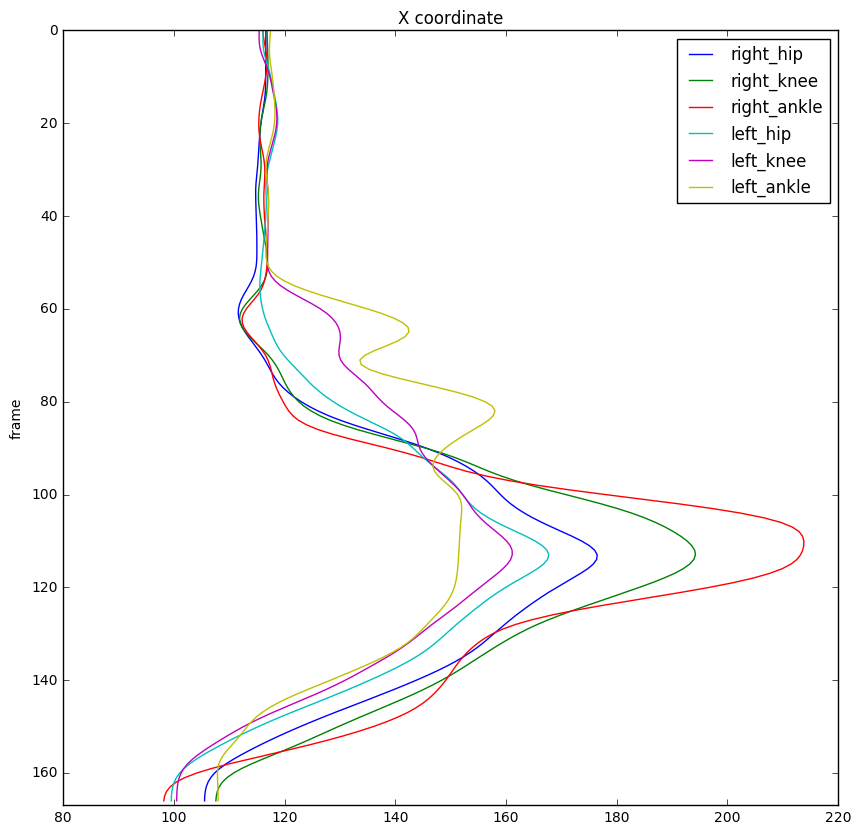

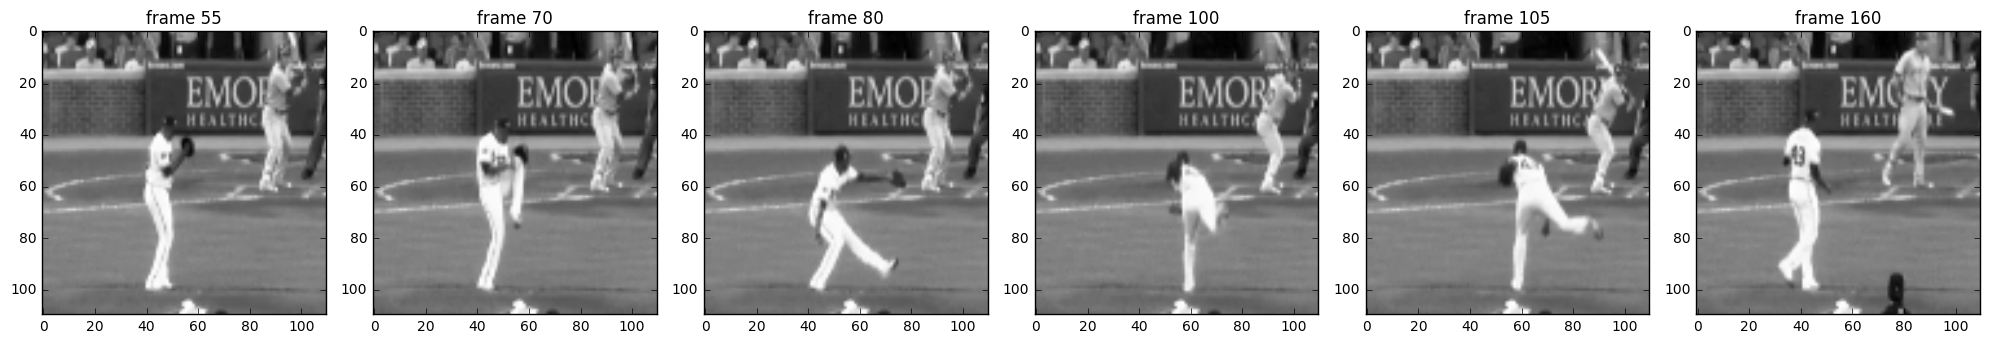

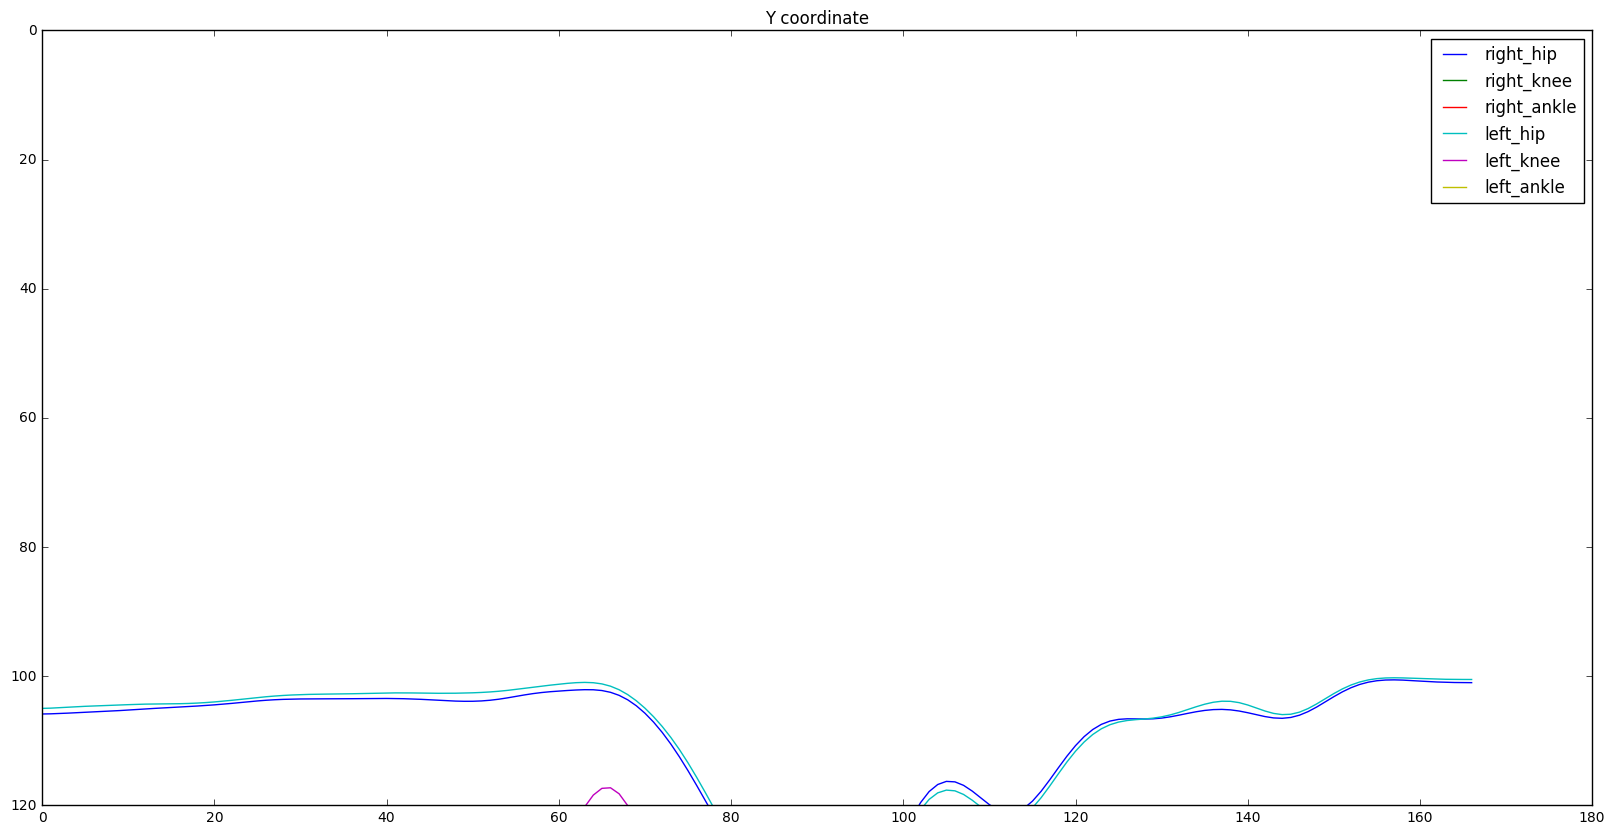

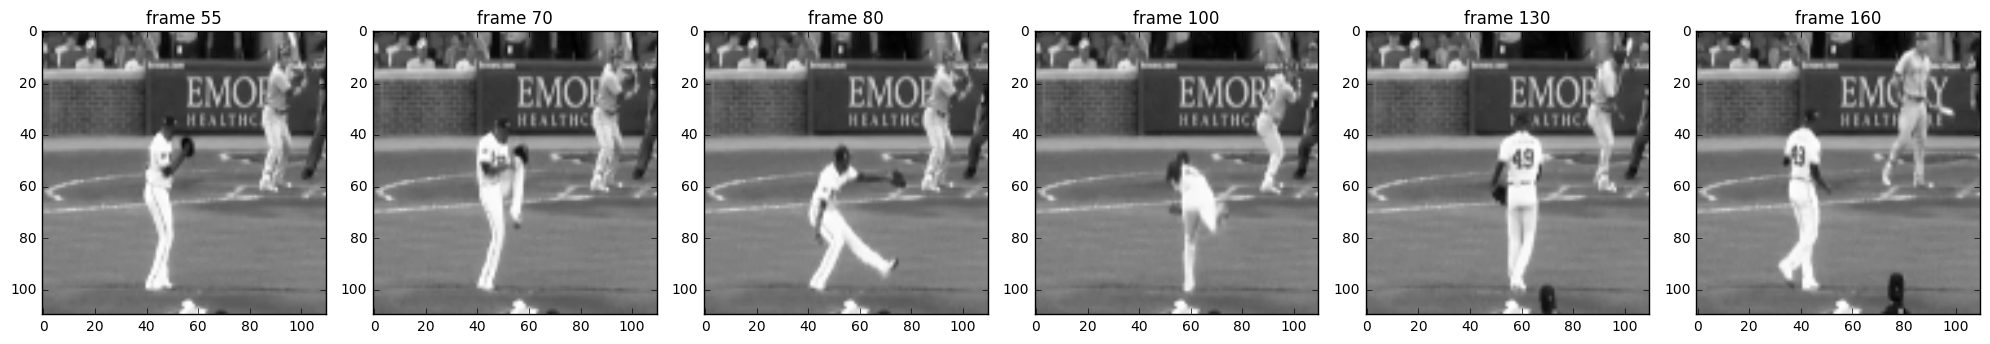

In [11]:
joints_list = ["right_shoulder", "left_shoulder", "right_elbow", "right_wrist","left_elbow", "left_wrist",
        "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle", "neck ",
        "right_eye", "right_ear","left_eye", "left_ear"]
# print(files)
one_joint = "left_knee"
video_choice = 28 #files.tolist().index("490972-90db4c70-5f8f-4a49-acc6-1cc6fe2537e0")
print(video_choice)

plt.figure(figsize = (10,10))
for j in joints_list[6:12]:
    plt.plot(joints_array[video_choice,:,joints_list.index(j), 1], np.arange(0,167,1), label = j)
plt.title("X coordinate")
plt.ylim(167,0)
plt.ylabel("frame")
plt.legend()
plt.show()

# Plot video frames to visualize maxima in X coordinates
show_frames = [55, 70, 80, 100, 105, 160]
fig = plt.figure(figsize=(20, 5))
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames),ind+1)
    plt.imshow(videos_p[video_choice,i])
    plt.title("frame "+str(i))
    plt.gray()
plt.tight_layout()
plt.show()


plt.figure(figsize = (20,10))
for j in joints_list[6:12]: #[one_joint]: 
    plt.plot(joints_array[video_choice,:,joints_list.index(j), 0], label = j)
plt.legend()
plt.ylim(120, 0)
plt.title("Y coordinate")
plt.show()

# Plot video frames to visualize maxima in Y coordinates
show_frames = [55, 70, 80, 100, 130, 160]
fig = plt.figure(figsize=(20, 5))
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames),ind+1)
    plt.imshow(videos_p[video_choice,i])
    plt.title("frame "+str(i))
plt.tight_layout()
plt.show()

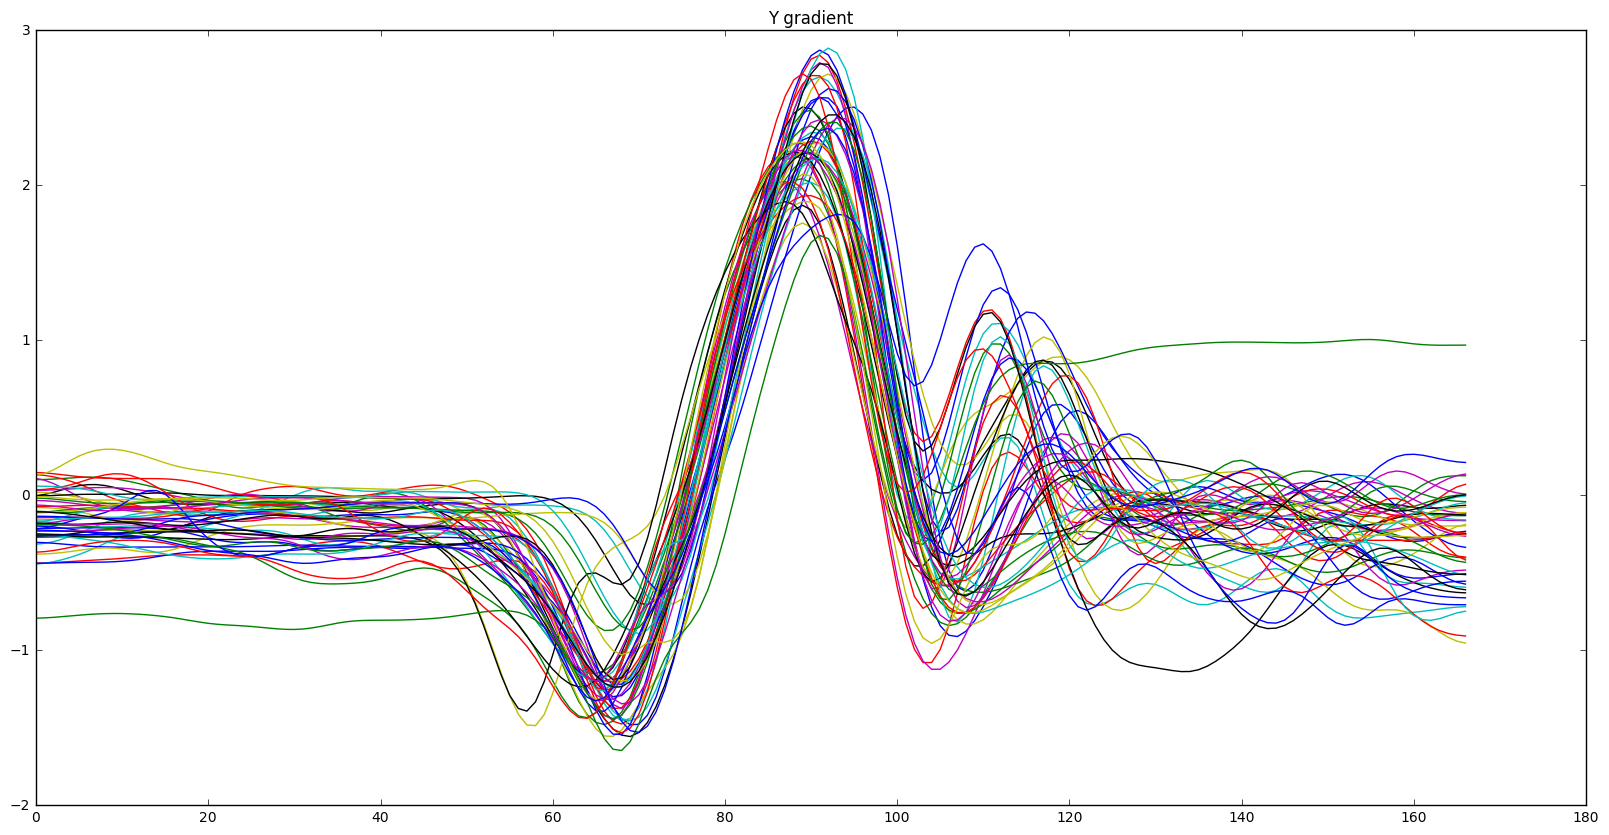

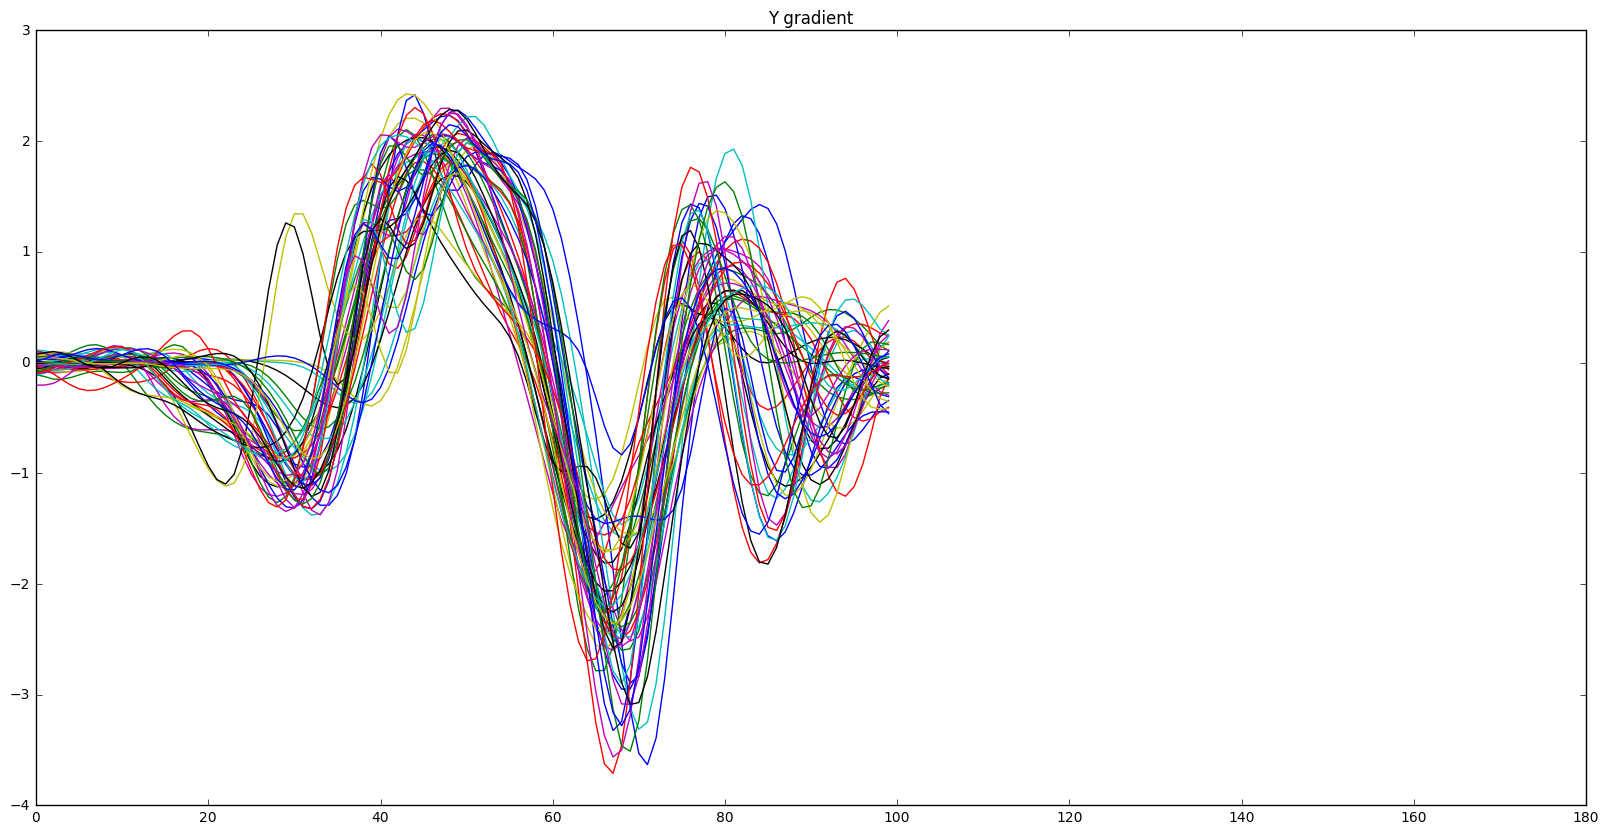

In [95]:
plt.figure(figsize = (20,10))
for video_choice in range(50):
    cut_to_joints = joints_array[video_choice,:,6:12, 0]
    me = np.mean(cut_to_joints, axis =0)
    std = np.std(cut_to_joints, axis =0)
    cut_to_joints =  np.array([(liste-me)/std for liste in cut_to_joints])
    # for j in joints_list[6:12]:
    #cut_to_joints = np.gradient(cut_to_joints, axis = 0)
    plt.plot(np.mean(cut_to_joints, axis = 1), label = release[video_choice])
#plt.legend()
#plt.ylim(200, 100)
plt.title("Y gradient")
plt.show()

def align_frames(data, release_frame, fr_before, fr_after):
    """
    data: four dim array with dims (data_length, #frames,
    nr_joints, nr_coordinates)
    release frame: must have same data_length as data and contain the
    frame of ball release for each corresponding sample
    fr_befoer: #frames considered before the ball release
    fr_after: # frames considered after ball release

    aligns the data around the ball release frame and cuts of other frames
    returns: data cut to shape (data_length, fr_after+fr_before,
    nr_joints, nr_coordinates)
    """
    M, _, nr_joints, nr_coord = data.shape
    new = np.zeros((M, fr_after+fr_before, nr_joints, nr_coord))
    for i, row in enumerate(data):
        ind = release_frame[i]
        start = int(ind-fr_before)
        end = int(ind+ fr_after)
        #print(start, end)
        new[i] = data[i, start:end, :,:]
    return new

aligned = align_frames(joints_array, release, 60, 40)

plt.figure(figsize = (20,10))
for video_choice in range(50):
    cut_to_joints = aligned[video_choice,:,6:12, 0]
    # for j in joints_list[6:12]:
    plt.plot(np.mean(np.gradient(cut_to_joints, axis = 0), axis = 1), label = release[video_choice])
#plt.legend()
plt.xlim(0, 180)
plt.title("Y gradient")
plt.show()

364
52
491015-77510376-58ec-43df-9707-c5266b70bce1
Windup


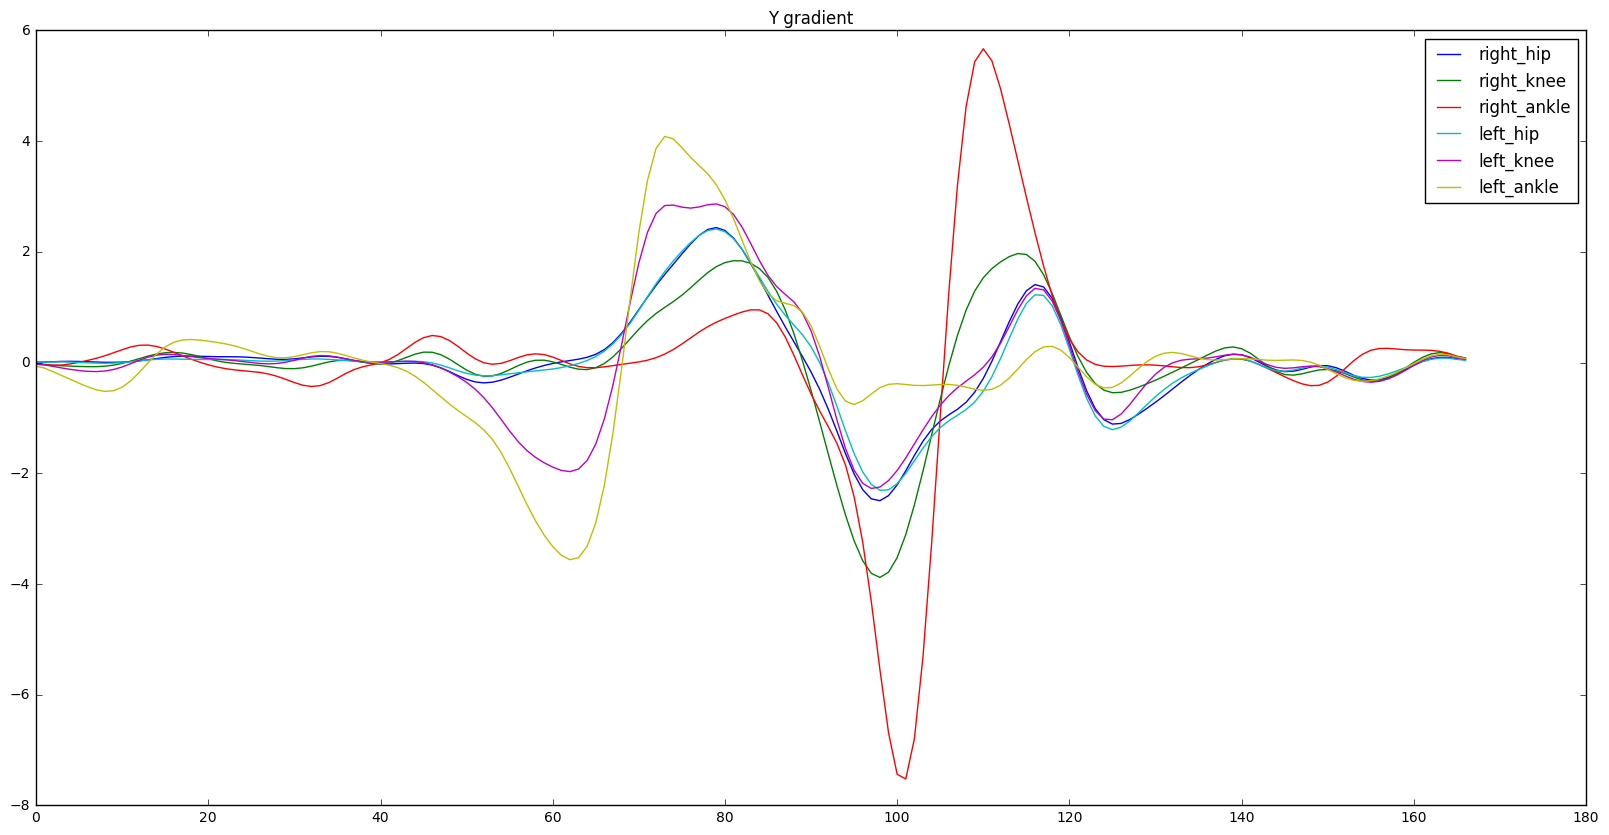

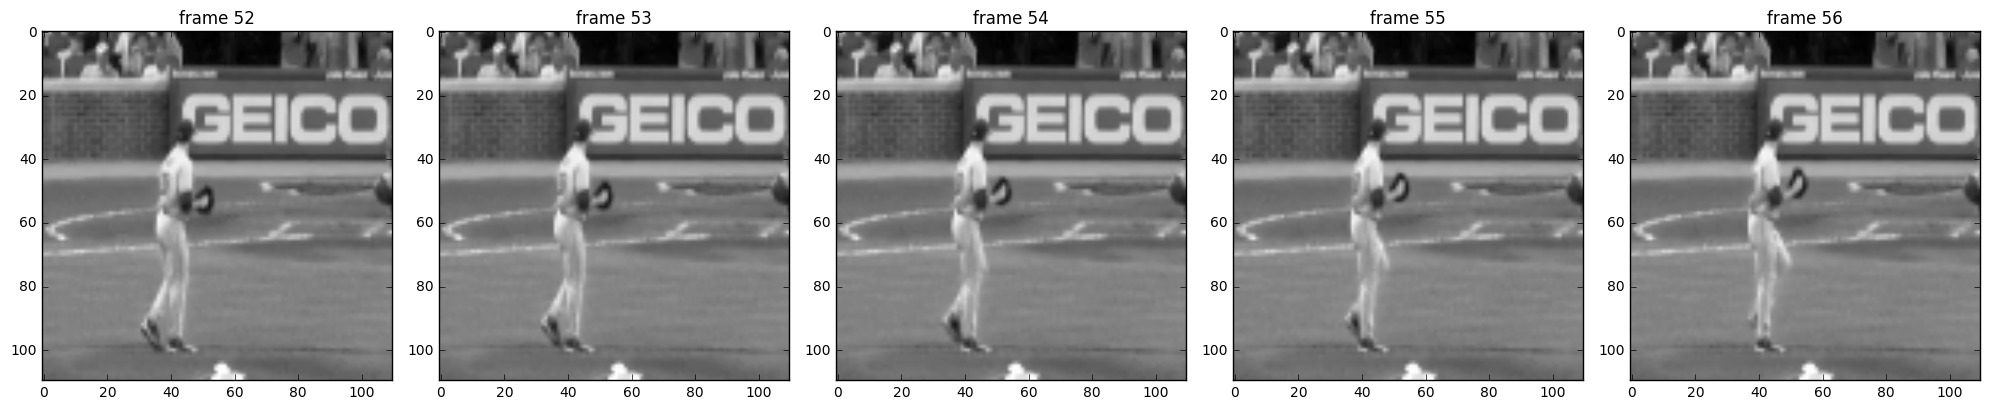

53
491015-ebffb928-983a-4602-b768-cd328597c0a5
Windup


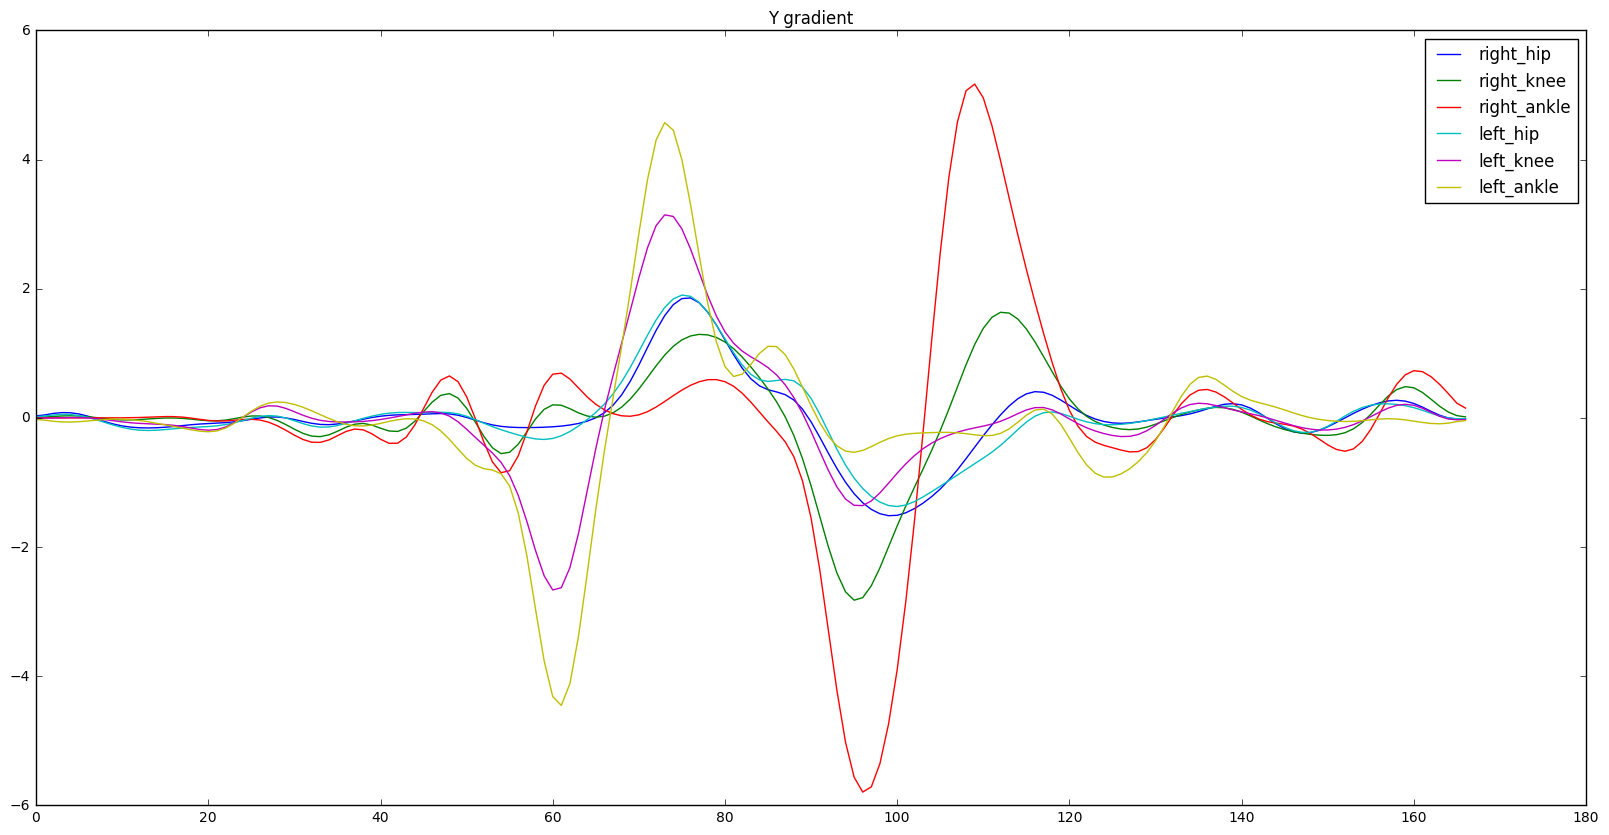

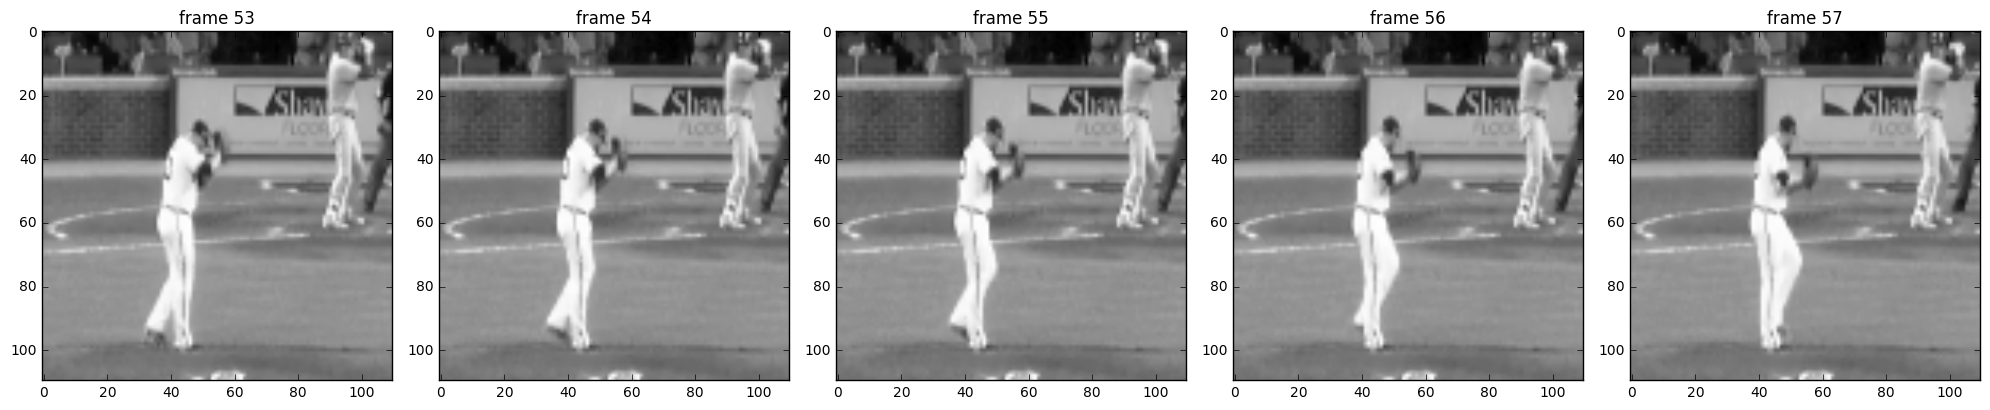

56
491015-527e139d-6837-4f1f-a02a-ff71661b2df2
Stretch


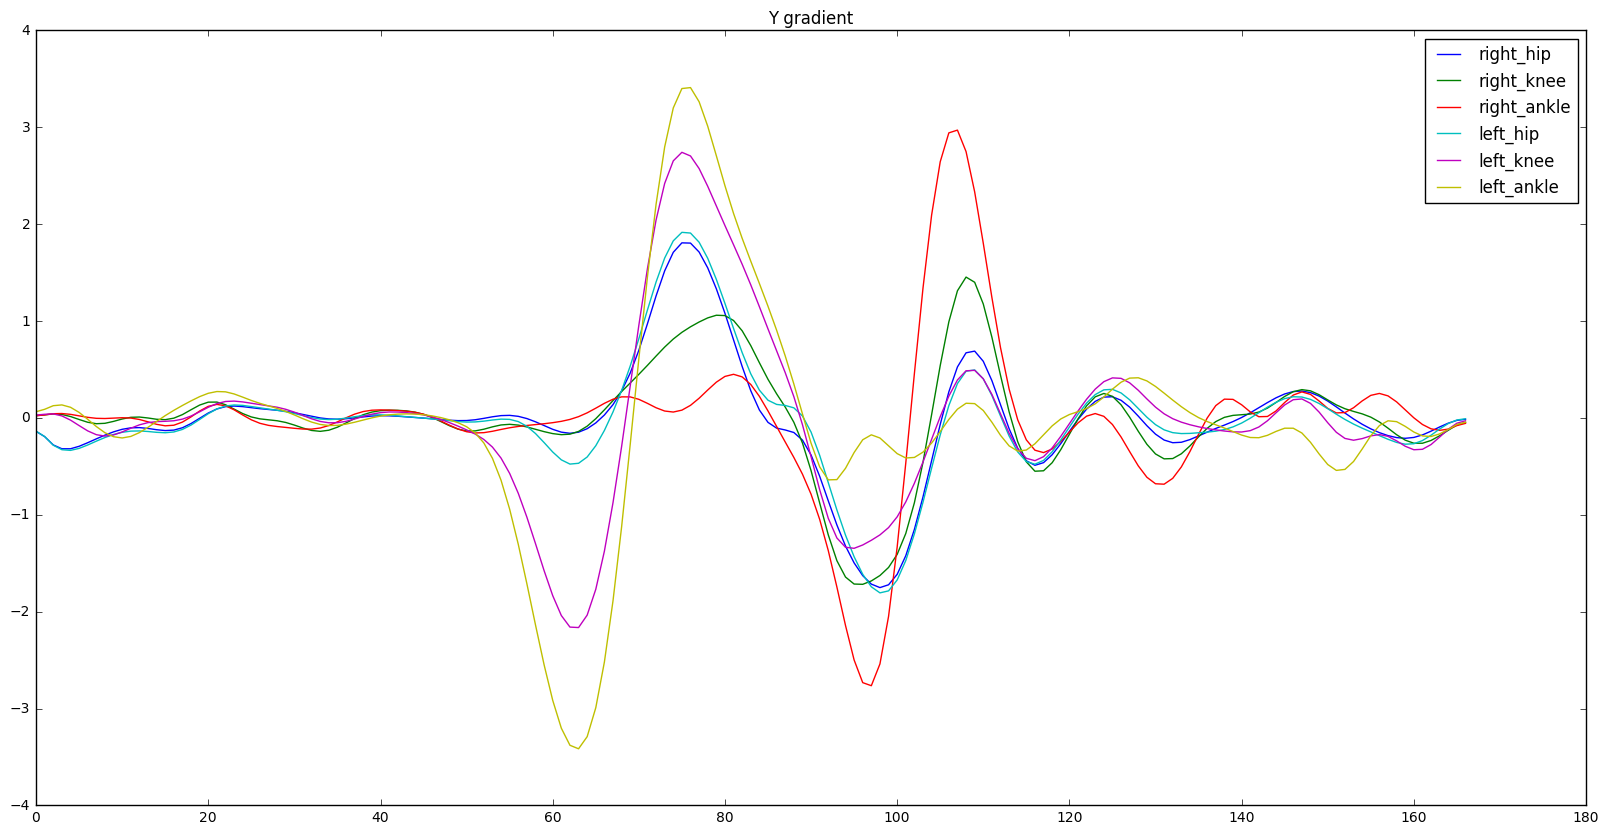

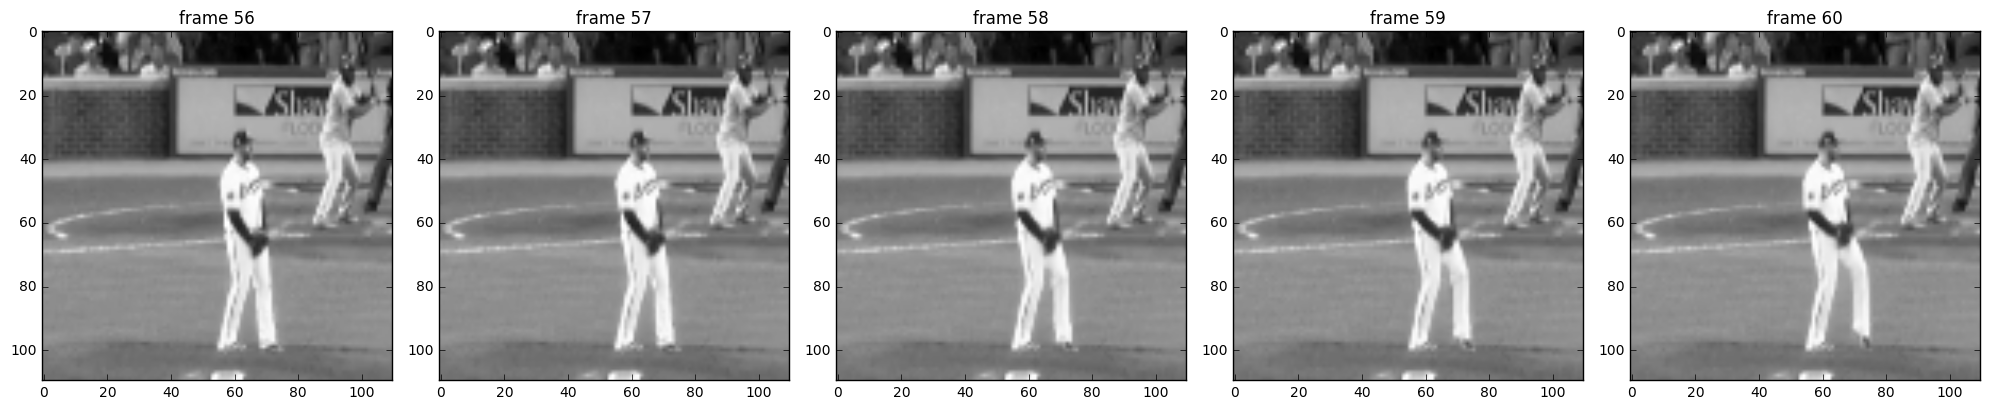

67
491015-161eea85-da69-47ba-9042-09bc5e2cc4c9
Stretch


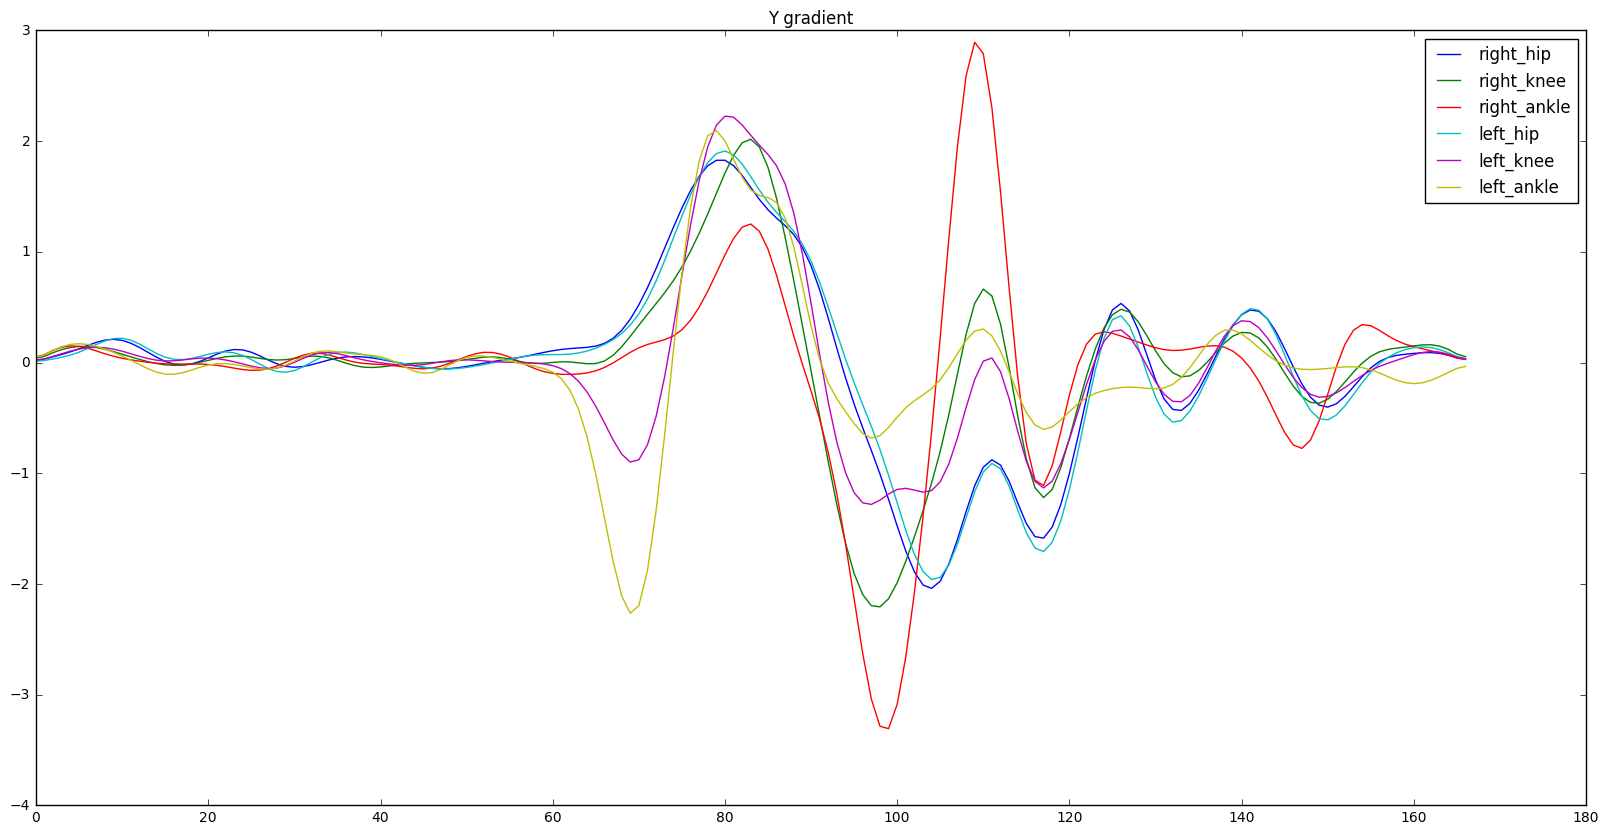

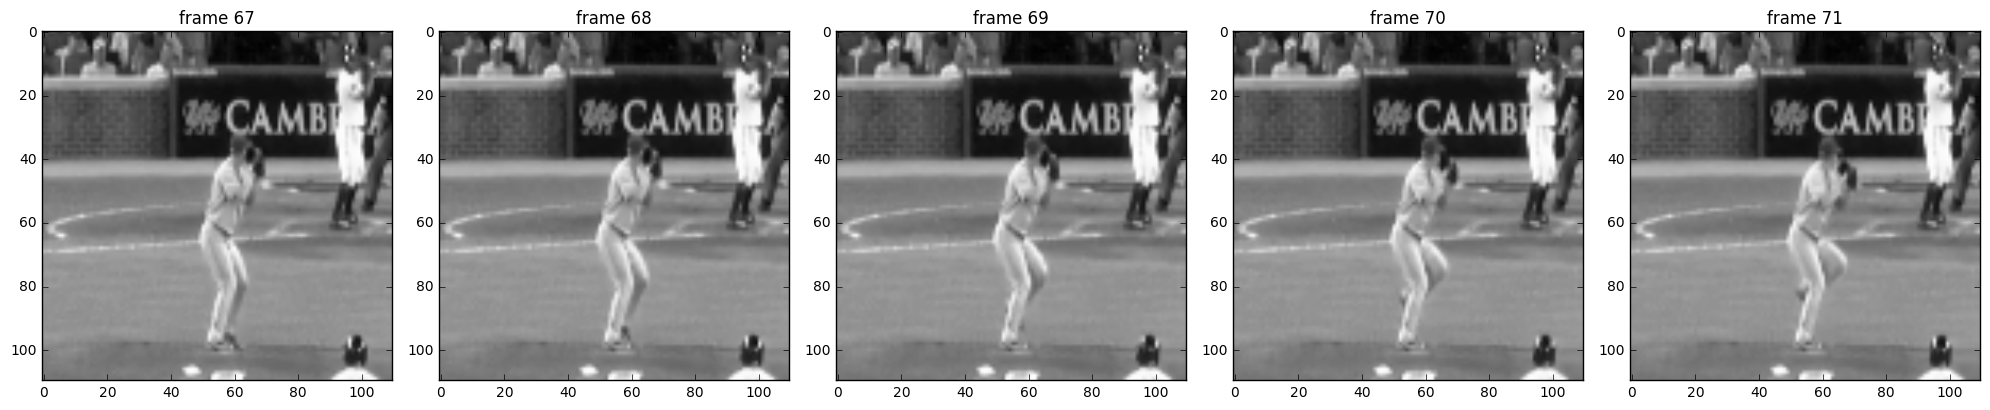

54
491015-9ae3a305-c072-43af-bf5c-d1513ddcb4f5
Stretch


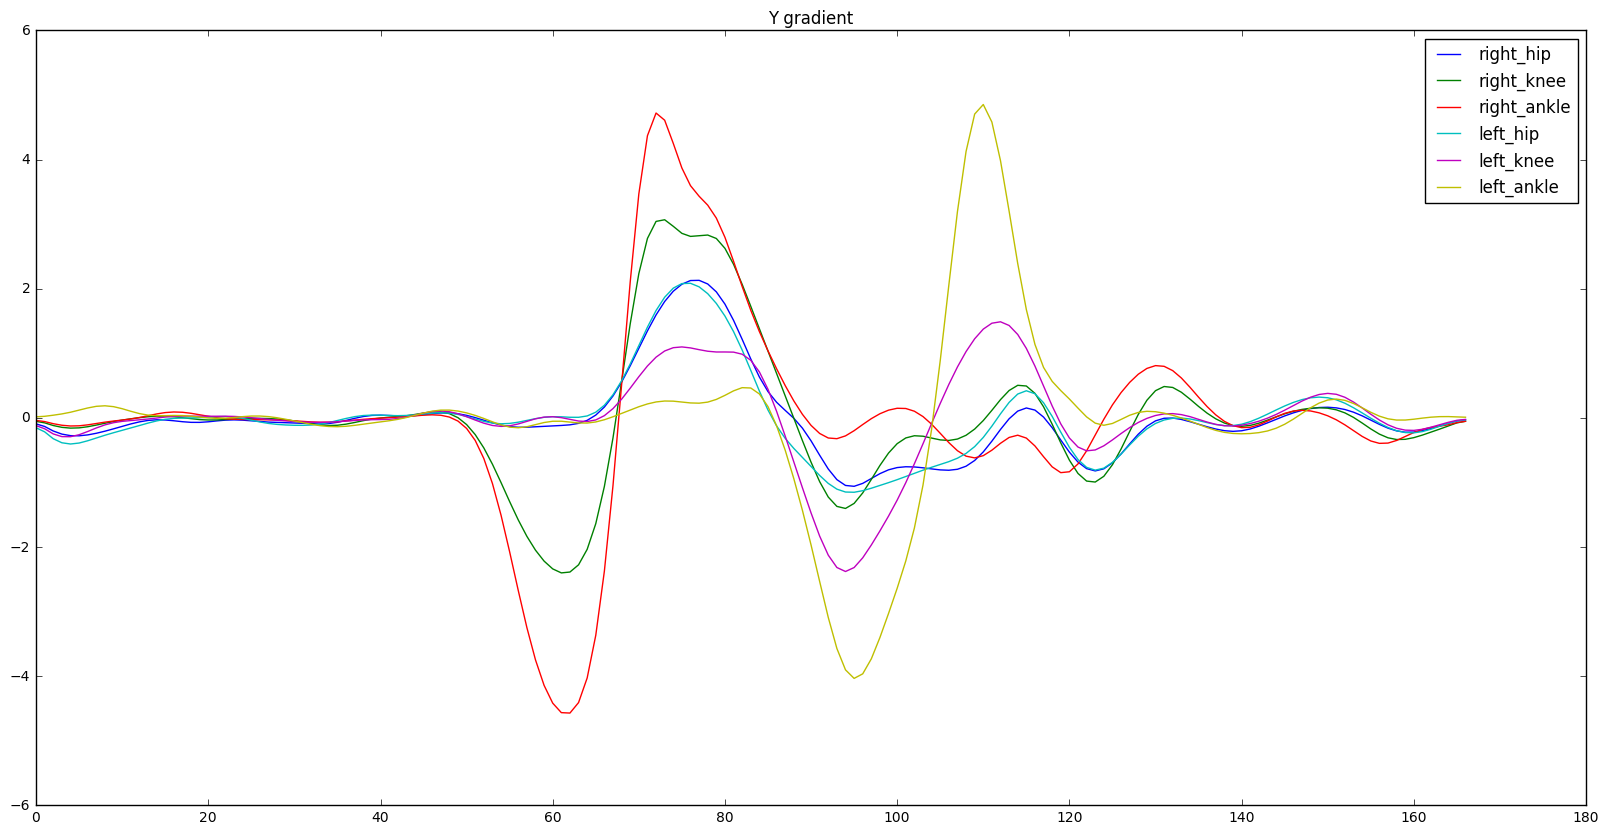

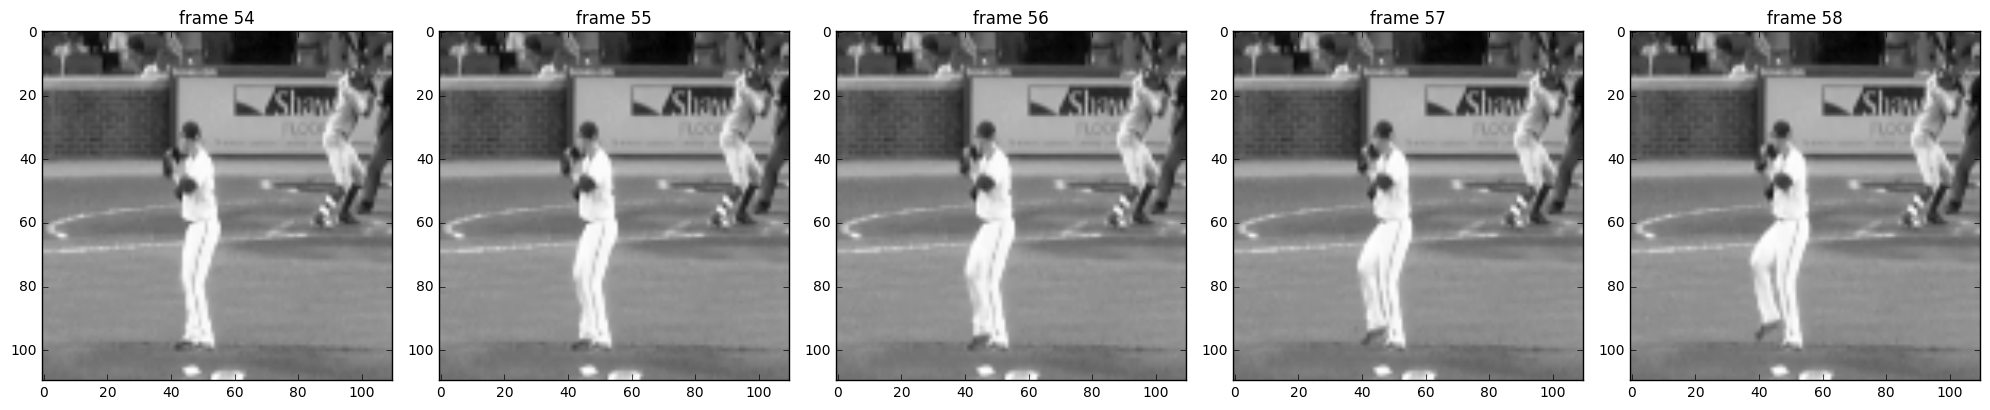

52
491015-83980784-6237-4807-9f40-1ec9b30c8181
Windup


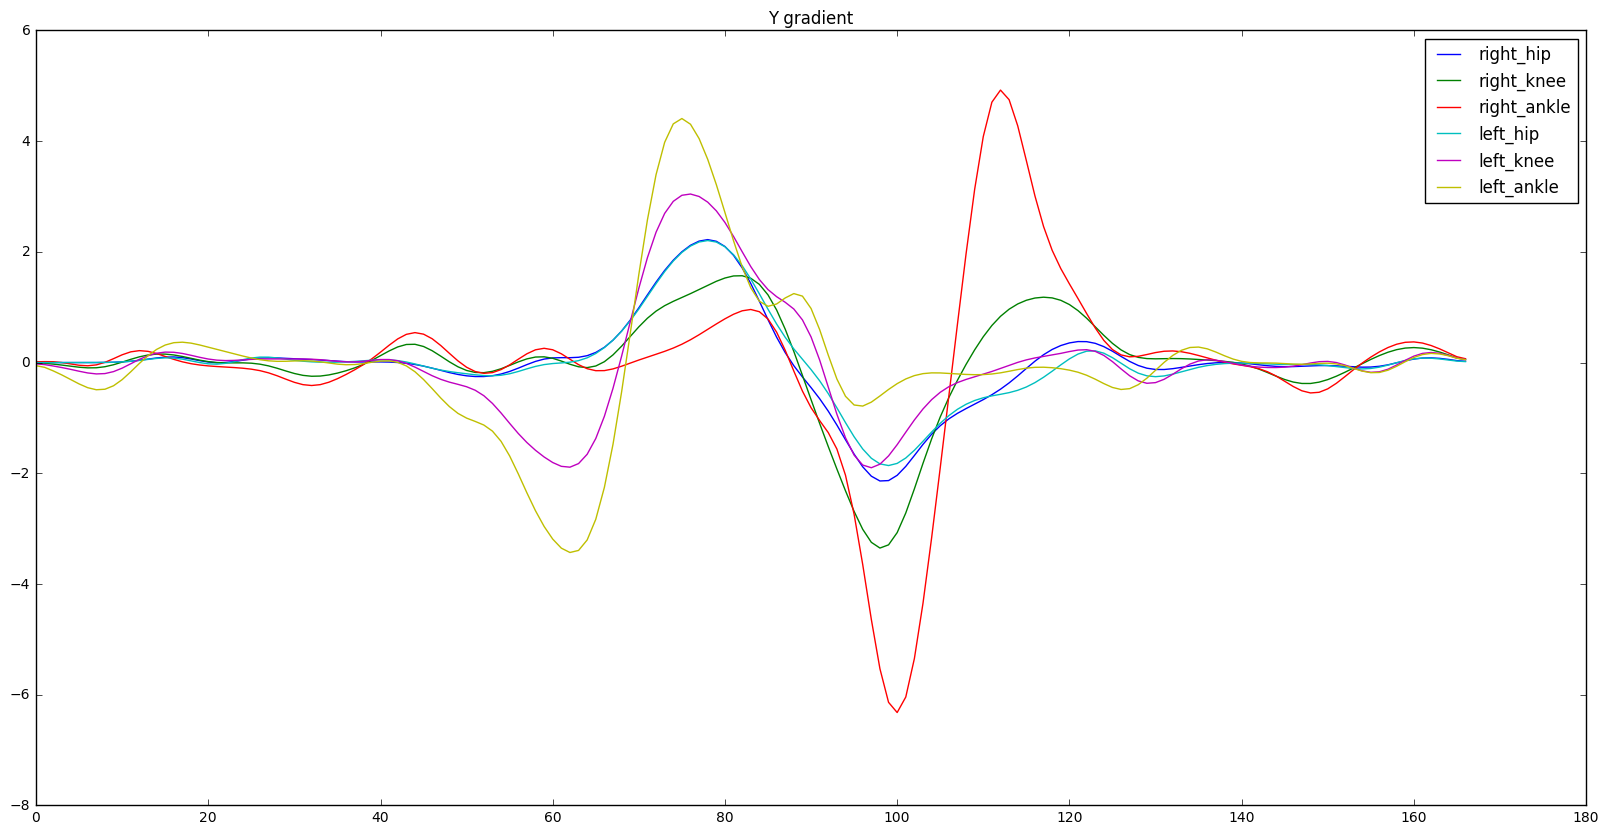

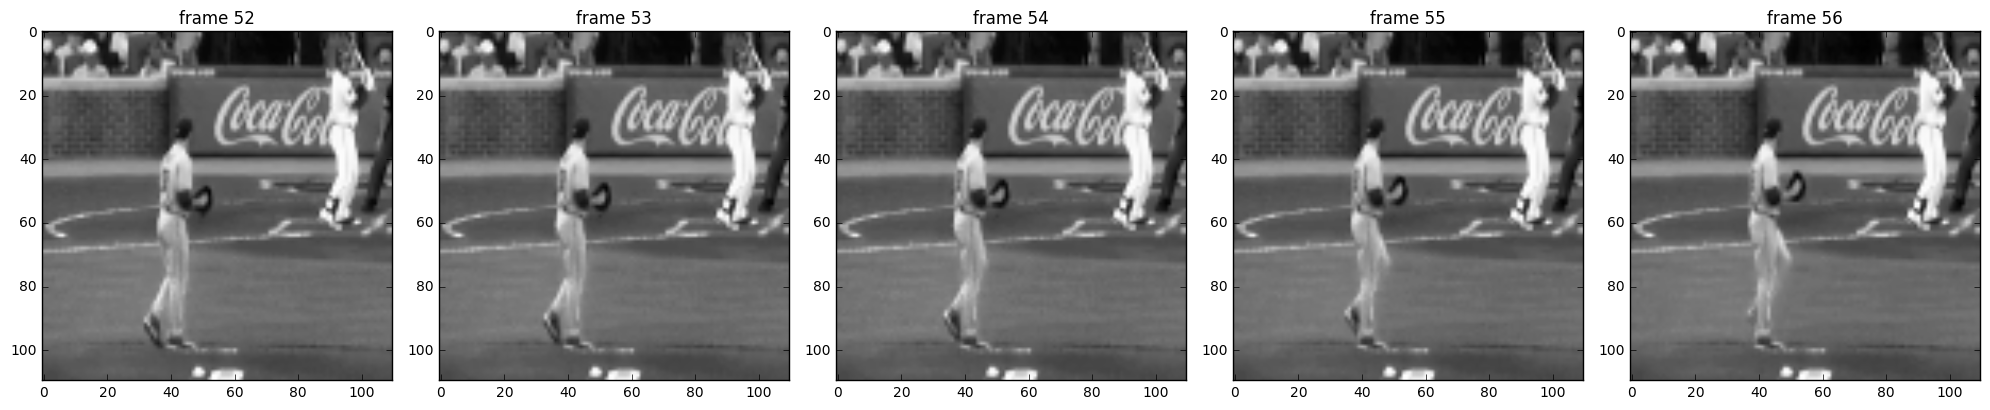

54
491015-a6b3ee25-89db-4991-bcdb-5743537b5cb2
Stretch


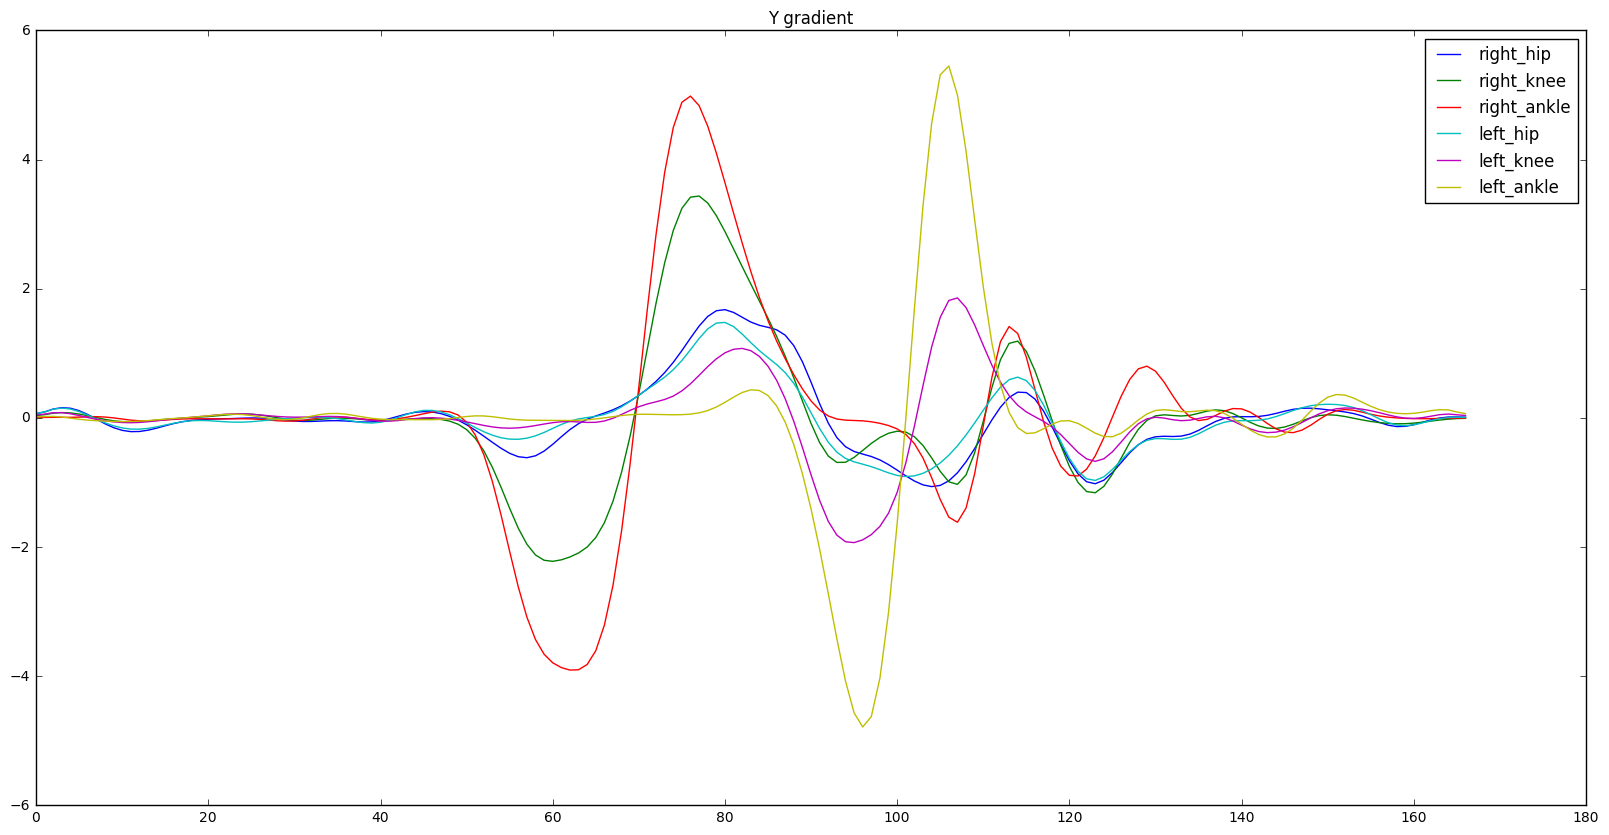

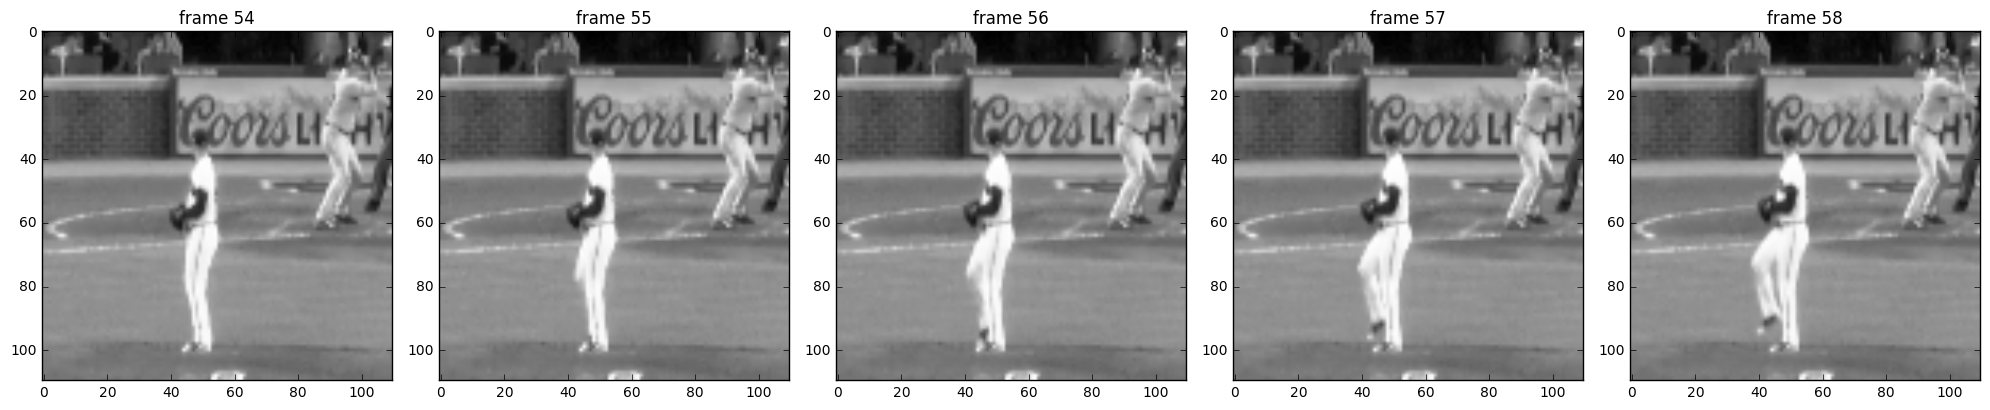

55
491015-7a24aa2e-e1df-4310-a5a7-becbf8d81e62
Unknown


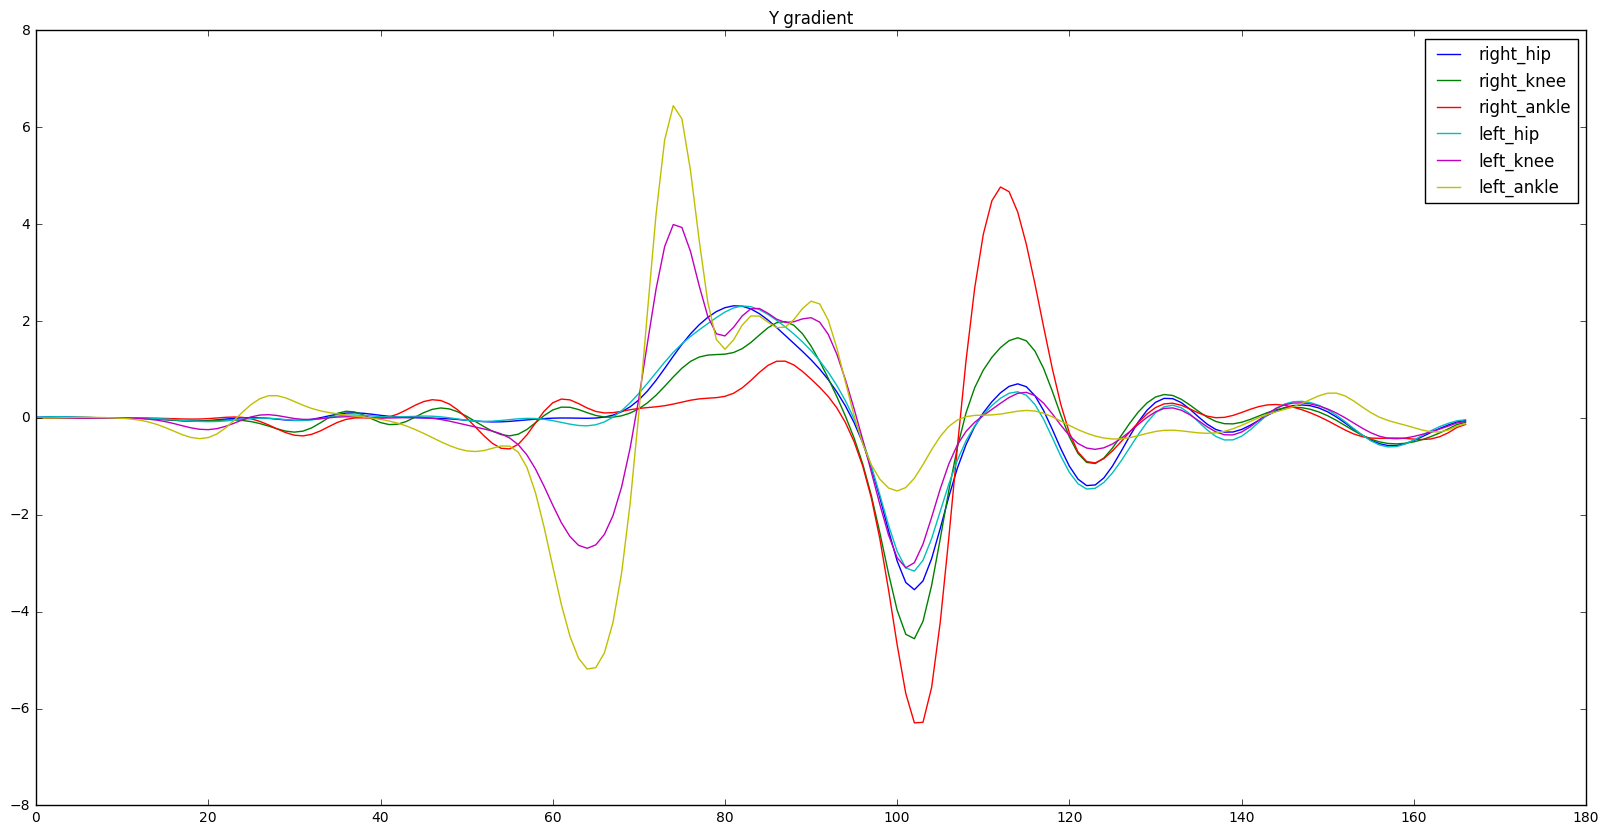

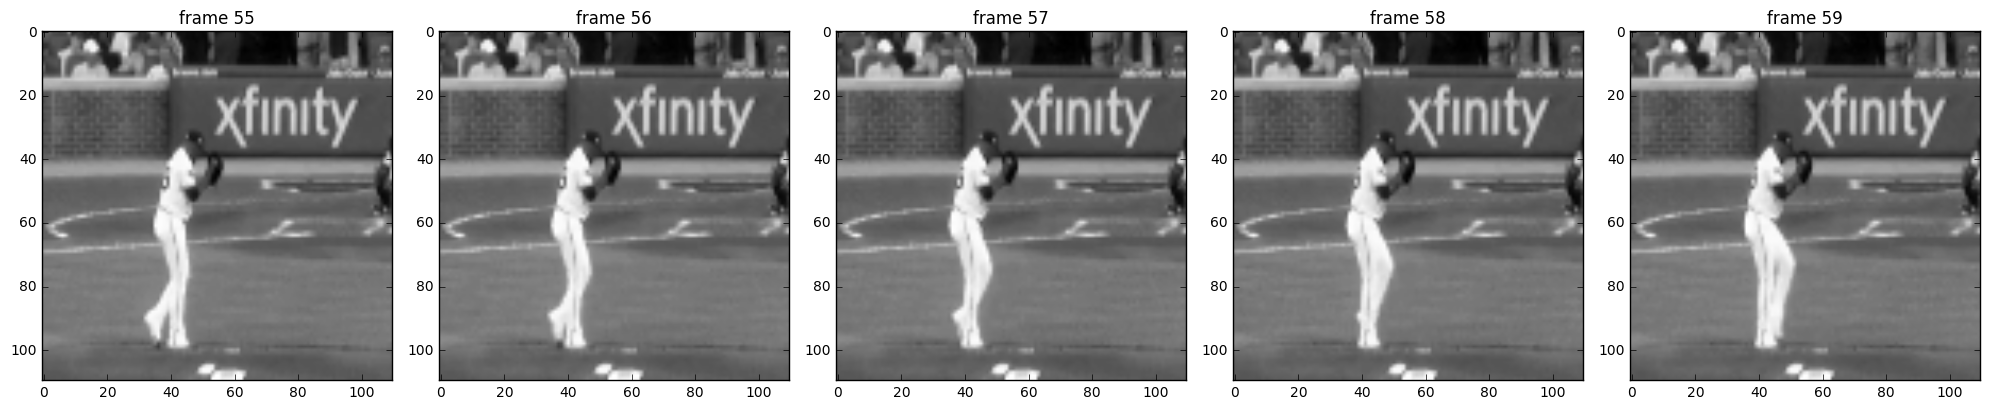

46
491015-4564749c-1b44-4b43-a849-efd47759f983
Windup


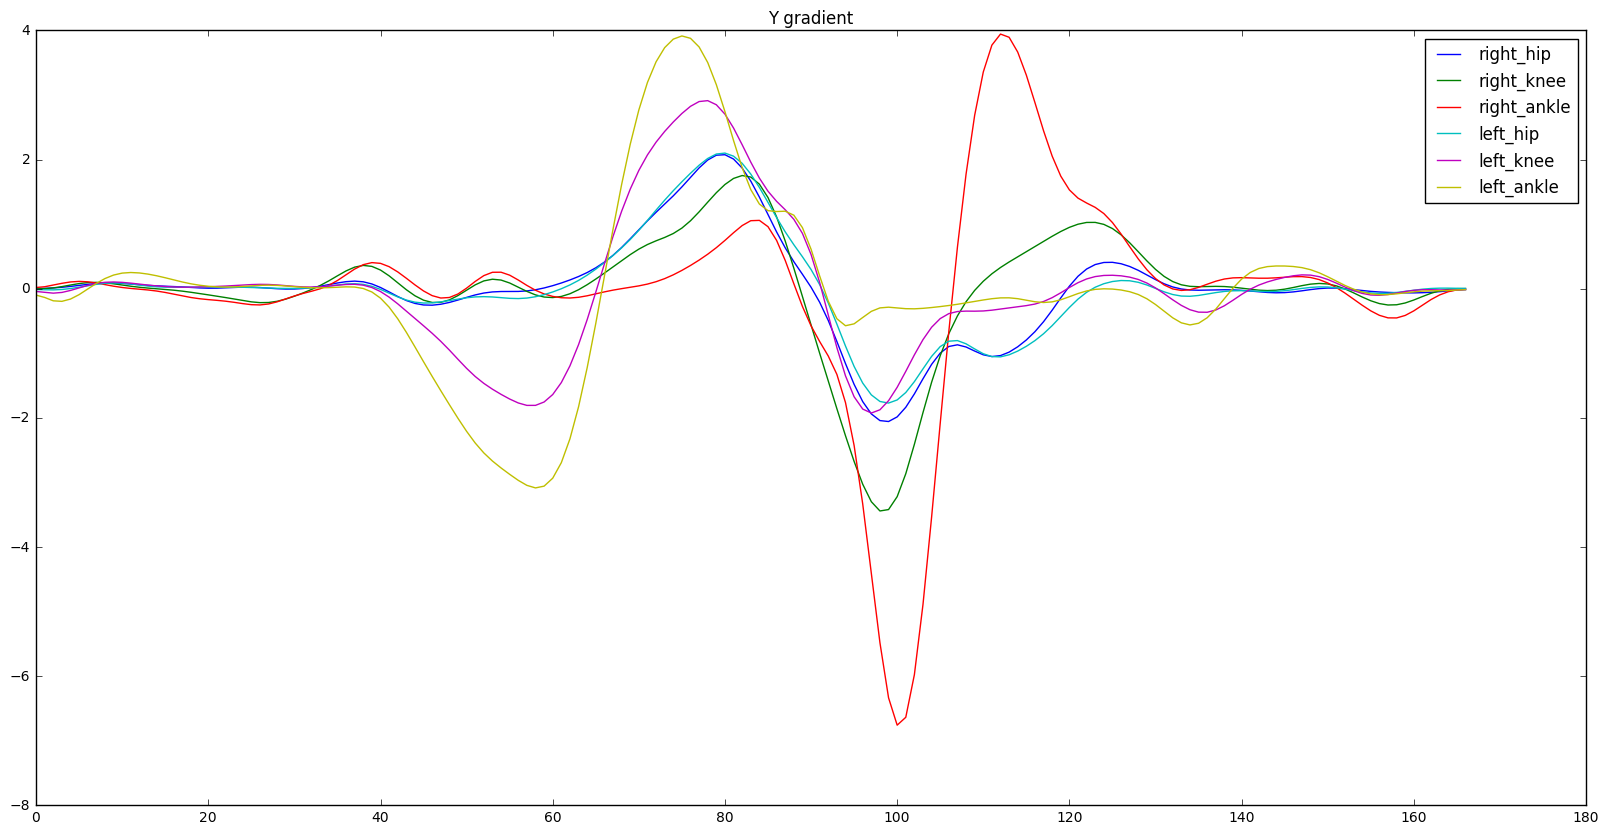

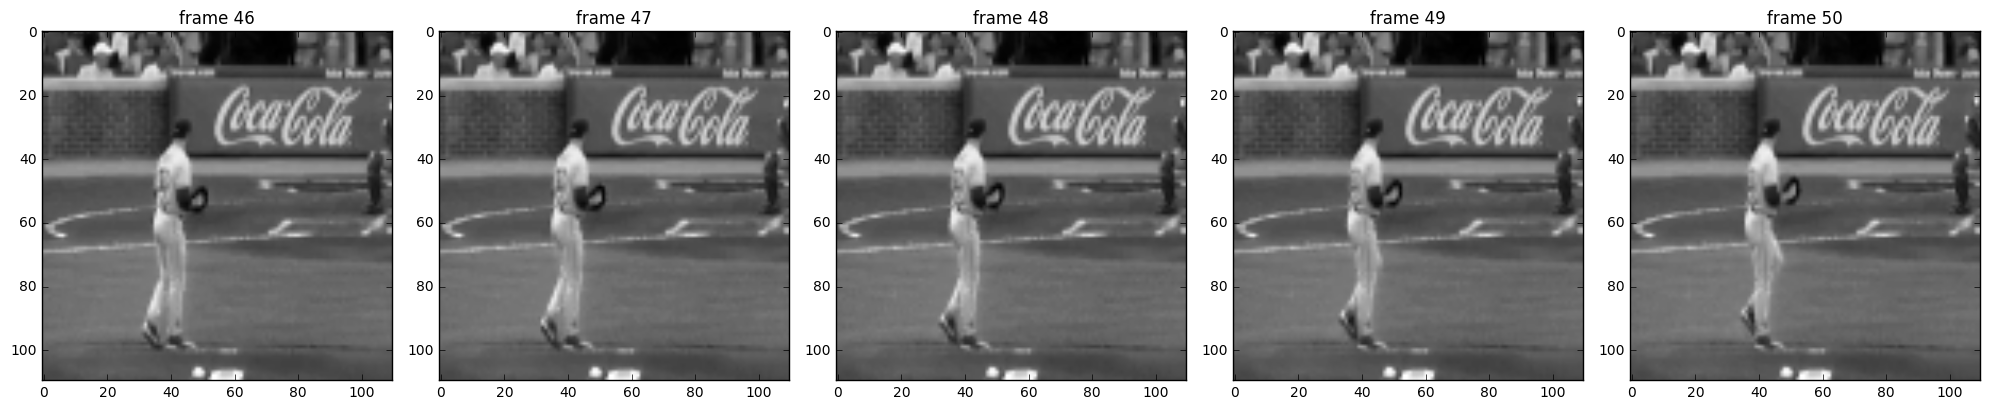

58
491015-aab561ec-5df2-46bf-afc7-28d443963d1b
Stretch


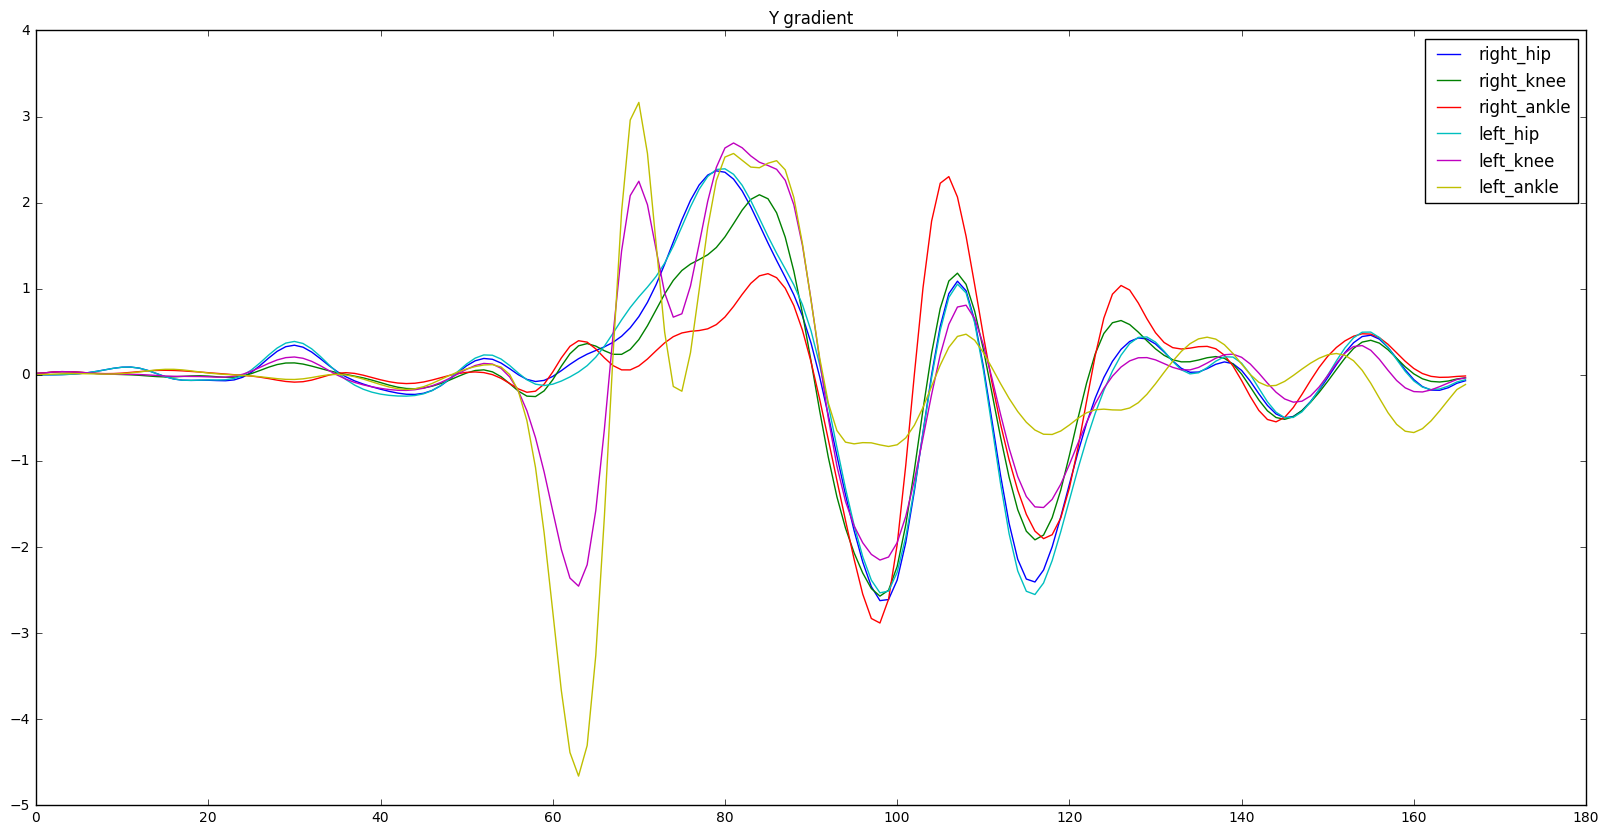

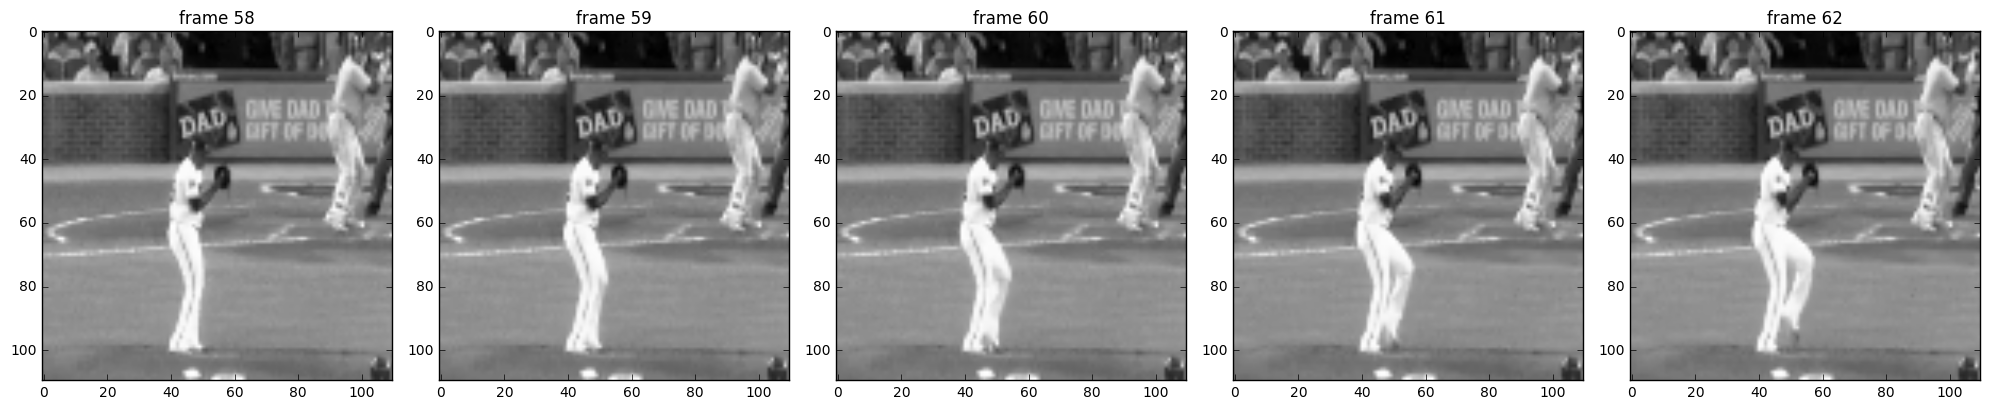

In [83]:
#print(joints_array[video_choice,:,joints_list.index(j), 0])

#test_set = joints_array[19,15:23, 7:12, 0]
#print(test_set)
with open("first_move_frames.json", "r") as infile:
    save_list = json.load(infile)

print(len(save_list))
labels_first_ten = []
for video_choice in range(10, 20): #20):
    # start = release[video_choice]-50
    relevant_joints = ["right_knee", "right_ankle", "left_knee", "left_ankle"]
    # for weird guy: ["right_shoulder", "left_shoulder", "right_elbow","left_elbow"]
    # first_move = first_leg(joints_array[video_choice,:,:, 0], relevant_joints, -0.3)
    # first_move = first_by_grad(joints_array[video_choice,:,:, 0], relevant_joints, -0.3)
    # first_move = grad_sum(joints_array[video_choice,:,:, 0], relevant_joints, 2)
    first_move = dtak_nn(joints_array[video_choice])
    print(first_move)
    if first_move is None:
        first_move = center_gravity(joints_array[video_choice, :, :, :12], joint_weights=np.array([1,1, 0.3,0, 0.3, 0, 1, 2,0.5, 1, 2, 0.5]), cutoff = 0.4)
    print(files[video_choice])
    print(pos[video_choice])
    save_list[files[video_choice]] = float(first_move)
    labels_first_ten.append(first_move)
    
    plt.figure(figsize = (20,10))
    for j in joints_list[6:12]:
        plt.plot(np.gradient(joints_array[video_choice,:,joints_list.index(j), 0]), label = j)
    plt.legend()
    #plt.ylim(200, 100)
    plt.title("Y gradient")
    plt.show()
    
    fig = plt.figure(figsize=(20, 5))
    show_frames = range(first_move, first_move+5) #[17, 18, 19, 20, 21]
    for ind, i in enumerate(show_frames):
        ax = fig.add_subplot(1,len(show_frames),ind+1)
        plt.imshow(videos_p[video_choice,i])
        plt.gray()
        plt.title("frame "+str(i))
    plt.tight_layout()
    plt.show()

In [32]:
#save_list["491001-85e200b5-1271-4b83-a224-06810e89648a"] = 79

with open("first_move_frames.json", 'w') as outfile:
    json.dump(save_list, outfile)
print(len(save_list))

364


# realtime check for first move

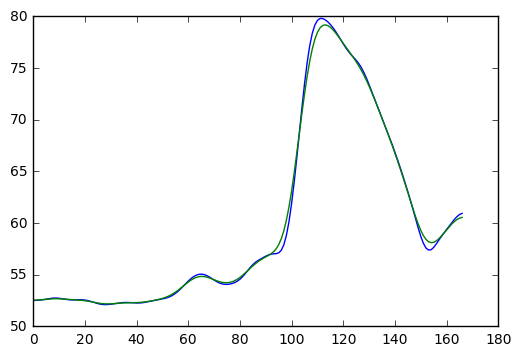

In [31]:
sequ = joints_array[0, :, :6, 0]
smooth = ndimage.filters.gaussian_filter1d(sequ, axis =0, sigma = 3)
# print(sequ.shape)
plt.plot(sequ[:,2])
plt.plot(smooth[:, 2], label = "sm")
plt.show()

first_by_grad [68 69 70]
start
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []
first_by_grad []


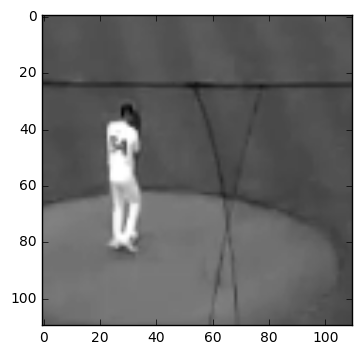

first_by_grad [68]
MOVE


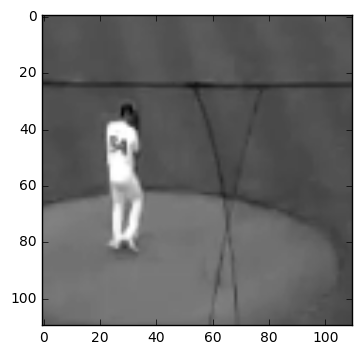

first_by_grad [68 69]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
first_by_grad [68 69 70]
fir

In [30]:
def is_first_move(frames_array, relevant_joints_list, cutoff):
    out = first_by_grad(frames_array, relevant_joints_list, cutoff)
    if out is None:
        return False
    else:
        return out==len(frames_array)-1

example = videos_p[0]
first_by_grad(joints_array[0,:,:,0], relevant_joints, -0.3)
print("start")
relevant_joints = ["right_knee", "right_ankle", "left_knee", "left_ankle"]
for i, fr in enumerate(example):
    #if i>4:
     #   print(is_first_move(joints_array[0,:i+1,:,0], relevant_joints, -0.3))
    if i>4 and is_first_move(joints_array[0,:i+1,:,0], relevant_joints, -0.3):
        print("MOVE")
        plt.imshow(fr)
        plt.show()

# Random stuff

In [ ]:
print(cf_batter.columns.tolist())
col = cf['First Step (1B)'].values
nonzero = np.logical_not(pd.isnull(col))
print(len(col), len(games_batter))
print(np.unique(col[nonzero]))
# TEST CURRENT FILES FOR  BATS
for i, filename in enumerate(files):
    game = filename
    ind_batter = games_batter.index(game)
    print(col[ind_batter])
#print(col[np.logical_not(])
for i in range(len(col)):
    if not pd.isnull(col[i]):
        print(games_batter[i], col[i])

In [ ]:
def fastest_arm_move(joints_arr):
    plt.figure(figsize = (20,10))
    for j in range(4):
        plt.plot(np.gradient(joints_array_batter[video_choice,:,j+2, 0]), label = j)
    plt.legend()
    plt.show()
    plt.figure(figsize = (20,10))
    for j in range(4):
        plt.plot(np.gradient(joints_array_batter[video_choice,:,j+2, 1]), label = j)
    plt.legend()
    plt.show()

In [ ]:
plt.figure(figsize = (5,10))
# for i, j in enumerate(joints_list[:18]):
plt.scatter(joints_array[2, 90, :12, 1], joints_array[2, 90, :12, 0]) #, label=j)
plt.legend(loc="top right")
plt.ylim(100,40)
plt.show()
plt.imshow(videos_p[2,90])
plt.show()

In [ ]:
data = np.load("bsp_data.npy")
lab = np.load("bsp_labels.npy")
data = ndimage.filters.gaussian_filter1d(data, axis =1, sigma = 1)
print(data.shape)
for i in range(10):
    print("------------next---------"," label", lab[i])
    bag = lab[i]//14
    for k in range(14):
        if k ==bag:
            print("HERE MOVE")
        d = data[i*14+k]
        
        gradients = np.array([np.gradient(d[:,j,0], edge_order = 2) for j in range(6)]) 
        print(gradients.shape)
        for j in range(6):
            plt.plot(gradients[j, :])
        plt.show()

        mean_gradient = np.mean(gradients, axis=0)
        #print(mean_gradient)
        move = np.where(mean_gradient<-0.3)[0]
        print(move)

# DTAK 

In [72]:
import argparse
import pandas as pd
import numpy as np
#WITHOUT /

def smooth(x,window_len=6,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """ 
     
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
        

    if window_len<3:
        return x
    
    
    #if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
    #    raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
    

    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y    

from numpy import array, zeros, argmin, inf, equal, ndim
from scipy.spatial.distance import cdist

def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

def fastdtw(x, y, dist):
    """
    Computes Dynamic Time Warping (DTW) of two sequences in a faster way.
    Instead of iterating through each element and calculating each distance,
    this uses the cdist function from scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)
    :param array x: N1*M array
    :param array y: N2*M array
    :param string or func dist: distance parameter for cdist. When string is given, cdist uses optimized functions for the distance metrics.
    If a string is passed, the distance function can be 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'wminkowski', 'yule'.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    if ndim(x)==1:
        x = x.reshape(-1,1)
    if ndim(y)==1:
        y = y.reshape(-1,1)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]
    D0[1:,1:] = cdist(x,y,dist)
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    if len(x)==1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1] / sum(D1.shape), C, D1, path

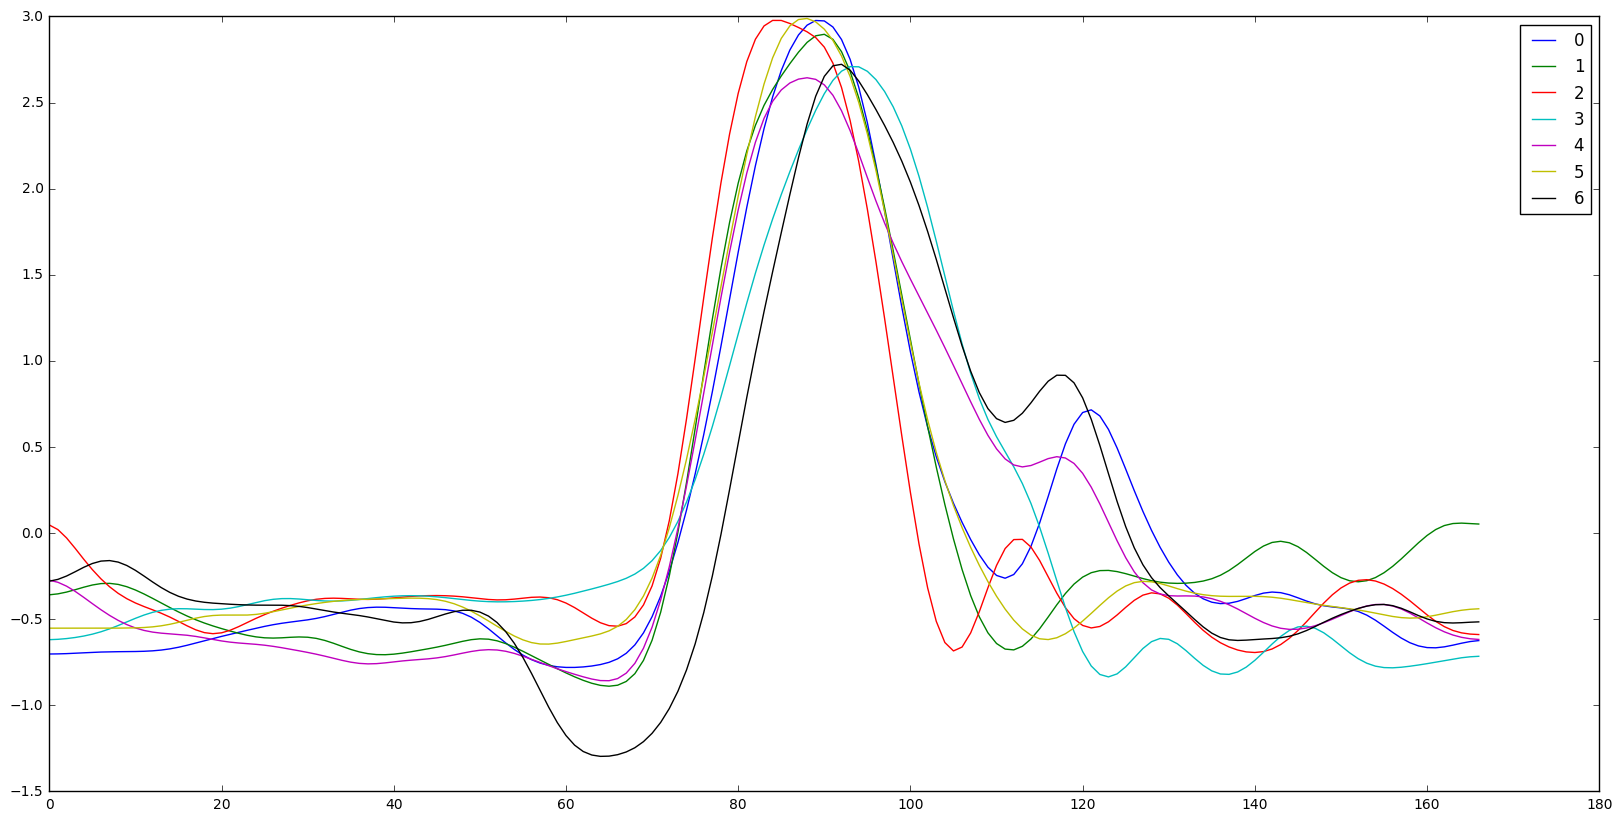

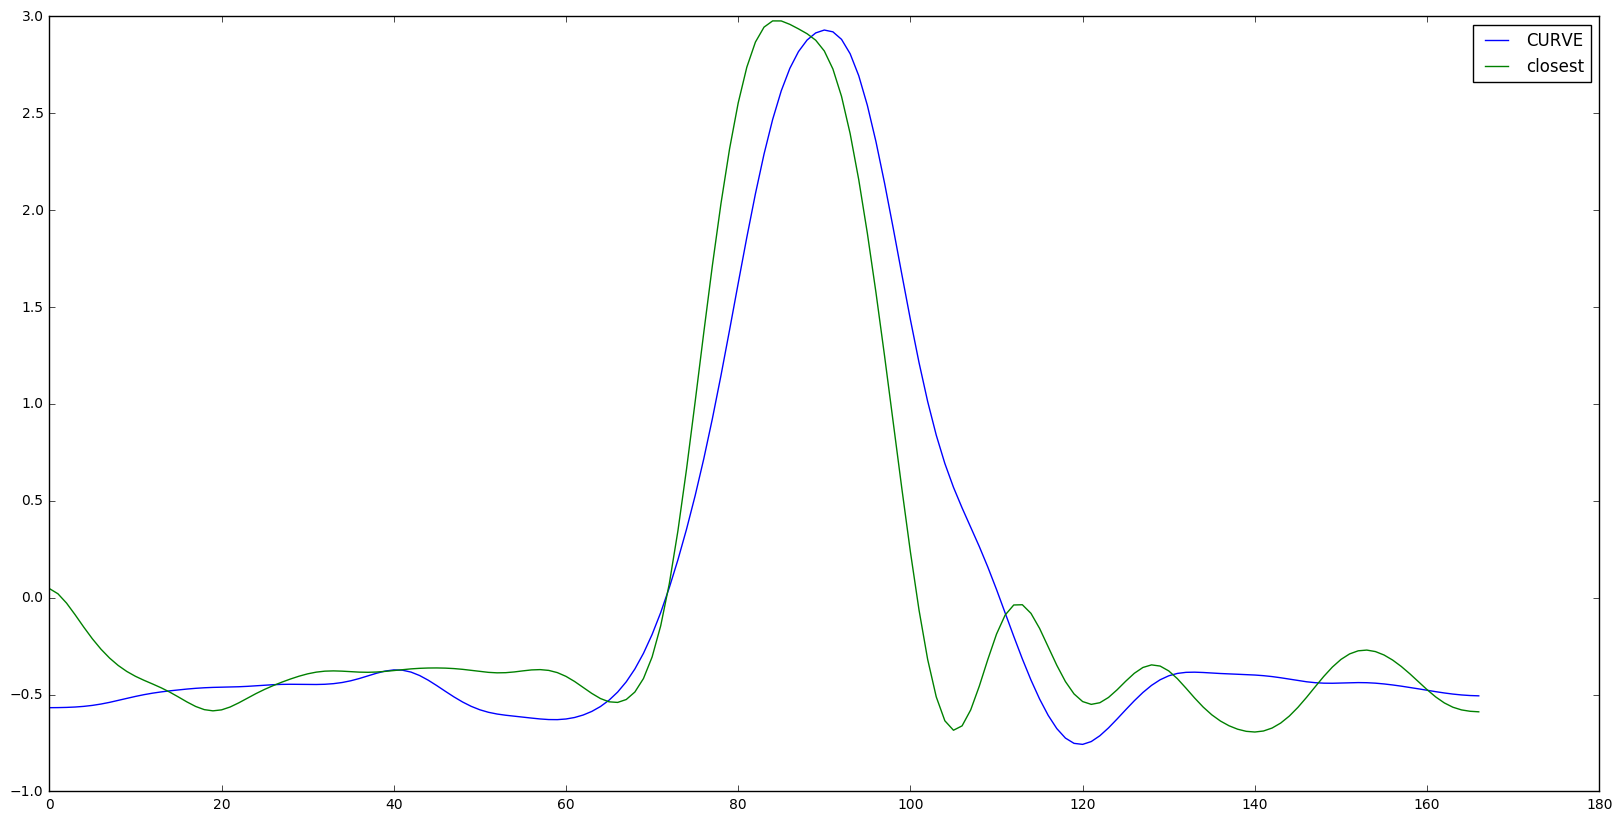

In [78]:
fig = plt.figure(figsize = (20,10))
distances = []
for i in range(7):
    sequ = joints_array[i,:,6,0]
    sequ = (sequ-np.mean(sequ))/np.std(sequ)
    plt.plot(sequ, label = i)
    x = sequ
    y = joints_array[8,:,6,0]
    dist, cost, acc, path = fastdtw(x, y, dist=lambda x, y: np.linalg.norm(x - y))
    distances.append(dist)
plt.legend()
plt.show()

fig = plt.figure(figsize = (20,10))
mini = np.argmin(distances)
sequ =joints_array[8,:,6,0] 
sequ = (sequ-np.mean(sequ))/np.std(sequ)
plt.plot(sequ, label = "CURVE")
sequ = joints_array[mini,:,6,0]
sequ = (sequ-np.mean(sequ))/np.std(sequ)
plt.plot(sequ, label = "closest")
plt.legend()
plt.show()

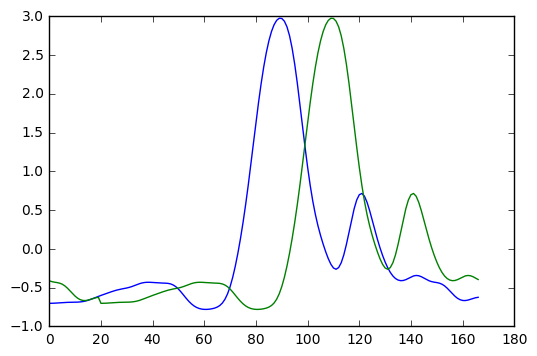

In [69]:
sequ1 = joints_array[mini,:,6,0]
sequ1 = (sequ1-np.mean(sequ1))/np.std(sequ1)
plt.plot(sequ1)
sequ2 =  np.roll(sequ1, 20) #joints_array[6,:,6,0]
sequ2 = (sequ2-np.mean(sequ2))/np.std(sequ2)
plt.plot(sequ2)
plt.show()

x = sequ1
y = sequ2
dist, cost, acc, path = fastdtw(x, y, dist=lambda x, y: np.linalg.norm(x - y))

In [93]:
def dtak_nn(play):
    joint = 6
    xy = 0
    distances = []
    test_sequ = play[:, joint, xy]
    test_sequ = (test_sequ-np.mean(test_sequ))/np.std(test_sequ)
    for i in range(len(labels_first_ten)):
        sequ = joints_array[i,:,joint,xy]
        sequ = (sequ-np.mean(sequ))/np.std(sequ)
        # plt.plot(sequ, label = i)
        x = sequ
        y = test_sequ
        dist, cost, acc, path = fastdtw(x, y, dist=lambda x, y: np.linalg.norm(x - y))
        distances.append(np.sum(cost))
    ind = np.argmin(distances)
    nn = joints_array[ind, :, joint, xy]
    nn = (nn-np.mean(nn))/np.std(nn)
    nn_label = labels_first_ten[ind]
    print("label nn", nn_label)
    x = nn
    y = test_sequ
    fig = plt.figure(figsize = (20,10))
    plt.plot(x, label = "nn")
    plt.plot(y, label = "test")
    plt.legend()
    plt.show()
    dist, cost, acc, path = fastdtw(x, y, dist=lambda x, y: np.linalg.norm(x - y))
    fig = plt.figure(figsize = (20,10))
    plt.plot(x[path[0]], label = "nn")
    plt.plot(y[path[1]], label = "test")
    plt.legend()
    plt.show()
    loc = list(path[0]).index(nn_label)
    print(loc)
    print(path[0][loc])
    res = path[1][loc]
    print("new label", res)

label nn 56


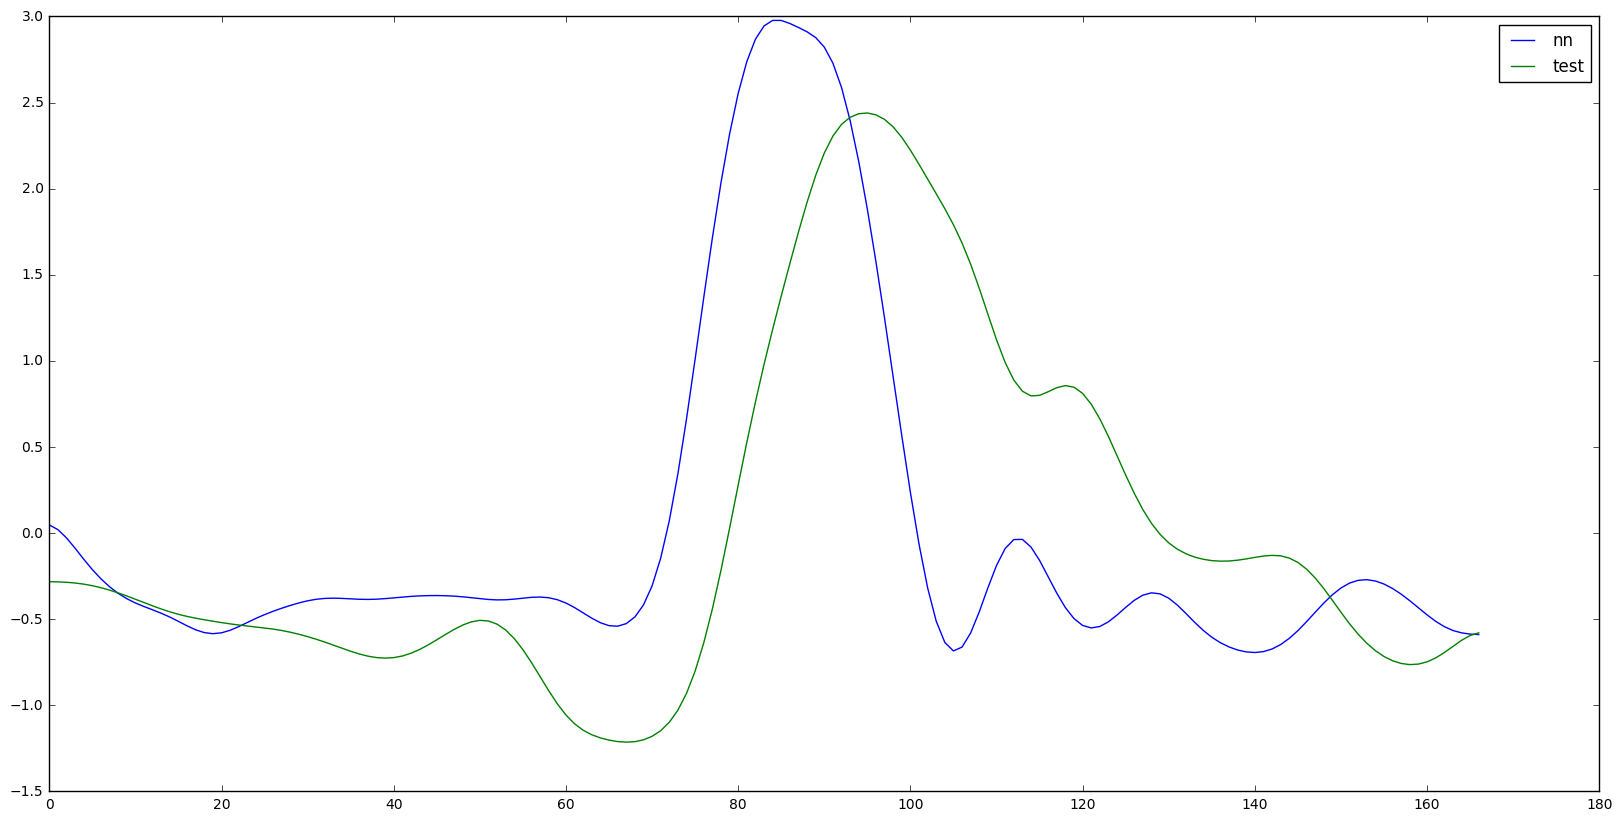

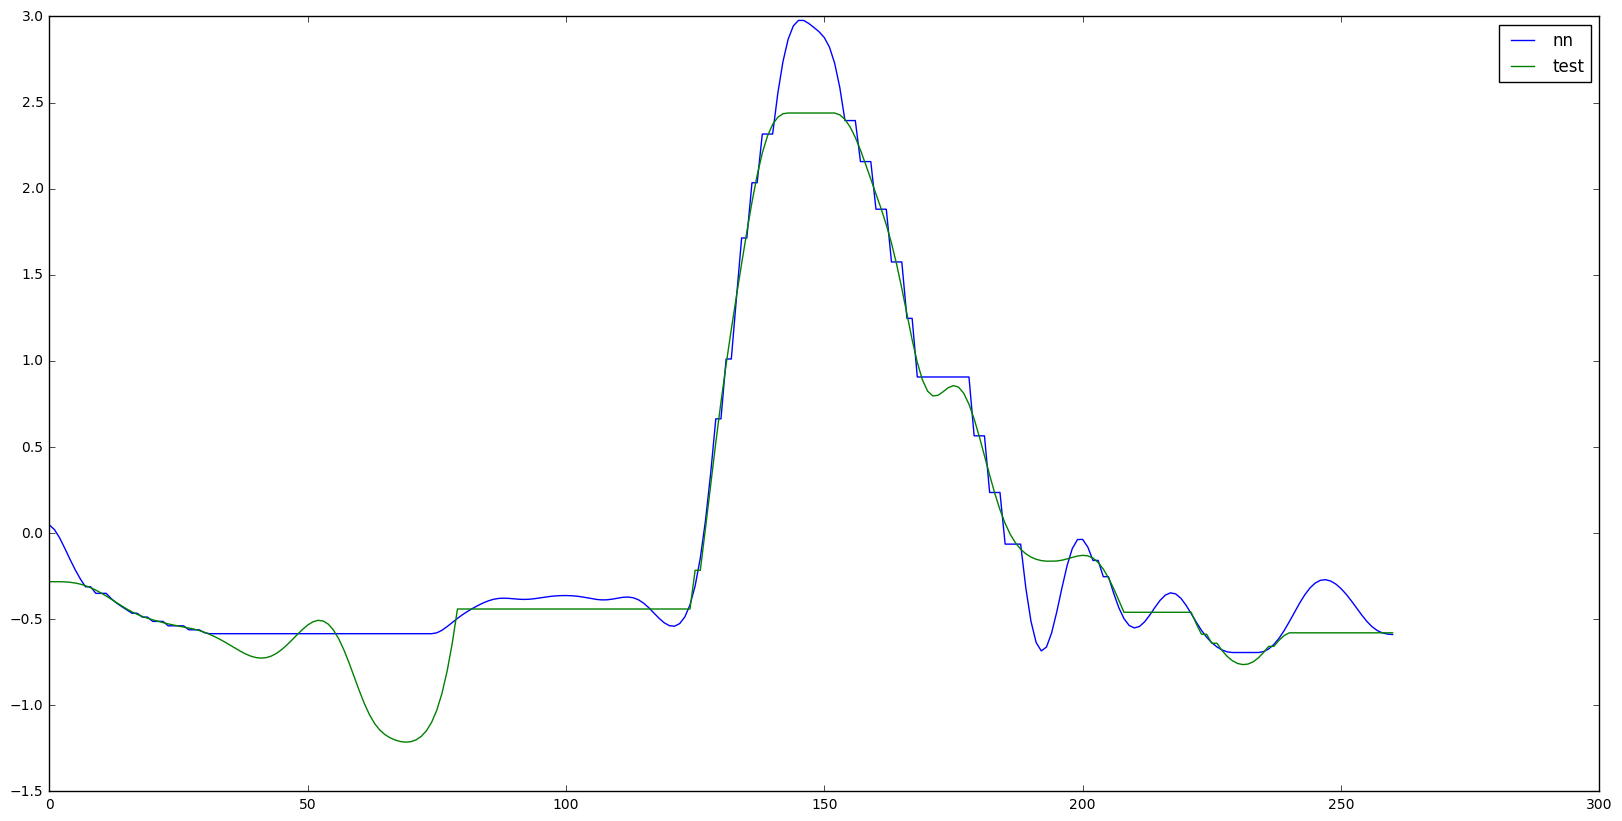

111
56
new label 77


In [94]:
dtak_nn(joints_array[12])

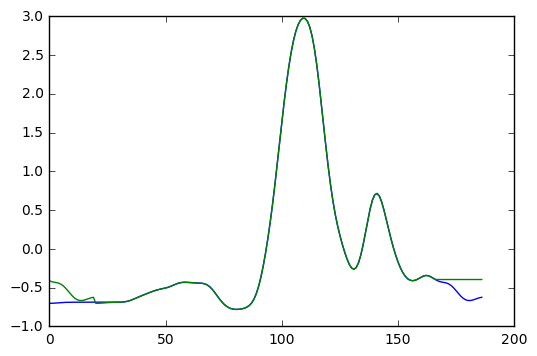

In [70]:
new1 = sequ1[path[0]]
new2 = sequ2[path[1]]
plt.plot(new1)
plt.plot(new2)
plt.show()

In [71]:
start = 60
print(sequ1[start])
print(sequ2[start])
loc = list(path[0]).index(start)
res = path[1][loc]
print(loc, res)

#print(new1[start])
#print(path[0][start])
#print(path[1][start])

-0.779828367082
-0.432748238241
80 80
